# A First Look into Layering: Analyzing When and Who to Take as Backup RBs
## Participant: Dylan Sloan
Twitter: https://twitter.com/dsloan__ (two underscores after dsloan)

Linkedin: https://www.linkedin.com/in/dylan-s-681721127/
## Introduction
A common question amongst best ball drafters is do backup running backs matter. If I draft two running backs early, can I wait till very late to get my backup running backs? Are handcuff running backs a good choice for my backup running back slots? My project aims to answer these questions by creating archetypes for running backs and looking at where RBs were drafted for all teams, playoff teams, and top 1% teams.


## Utilities

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [2]:
dir_fast = '/Users/dylansloan/Desktop/best-ball-data-bowl-master/data/2022/regular_season/fast/part_'
dir_mixed = '/Users/dylansloan/Desktop/best-ball-data-bowl-master/data/2022/regular_season/mixed/part_'
extension = '.csv'
filepaths = [dir_fast + str(i).zfill(2) + extension for i in range(27)]
filepaths += [dir_mixed + str(i).zfill(2) + extension for i in range(9)]
df_2022 = pd.concat([pd.read_csv(fp) for fp in filepaths])

In [3]:
dir_path = '/Users/dylansloan/Desktop/best-ball-data-bowl-master/data/2021/regular_season/part_'
extension = '.csv'
filepaths = [dir_path + str(i).zfill(2) + extension for i in range(6)]
df_2021 = pd.concat([pd.read_csv(fp) for fp in filepaths])

In [4]:
clay_proj2021=pd.read_csv('/Users/dylansloan/Downloads/Mike Clay 2021 Projection - Sheet1 (3).csv')
clay_proj2022=pd.read_csv('/Users/dylansloan/Downloads/2022 Clay Projections - Sheet1 (3).csv')

## Establishing Closing Line ADP
In order to create adp_difference which will be seen later, I needed to gather the ADPs of all the running backs. However, the ADPs of players change from the start of draft season to the end. In order to get more of a source of truth, I took the ADPs from within a week before the contest closed.

In [5]:
df_2021['draft_time'] = pd.to_datetime(df_2021['draft_time'])
filtered_df2021 = df_2021[df_2021['draft_time'].dt.date == pd.to_datetime('2021-09-08').date()]
df_2022['draft_time'] = pd.to_datetime(df_2022['draft_time'])
filtered_df2022 = df_2022[df_2022['draft_time'].dt.date == pd.to_datetime('2022-09-06').date()]

## Creating A Playoff Team Subset in 2022
While the 2021 dataset had playoff_team properly assigned, the 2022 data did not. In the code below, I go about assigning this column as it will be used later in the project.

In [6]:
df_2022['rank'] = df_2022.groupby('draft_id')['roster_points'].rank(method='dense', ascending=False)
df_2022['playoff_team'] = np.where(df_2022['rank'] <= 2, 1, 0)
df_2022 = df_2022.drop('rank', axis=1)

## ADP Difference
The ADP Difference idea comes from RotoViz’s Charles Kleinheksel who deciphered that a gap in adp of 97.5 from RB1 to RB2 on a team was enough to decipher whether a RB was a backup/starter situation or it was a committee situation. If the gap is larger than 97.5 it is declared a starter and backup and if less than it is a committee. I went about doing this in the code by getting a unique list of RBs and their closing line adp (projection_adp) and then creating adp_difference between the first two running backs selected.

In [7]:
running_backs2021 = filtered_df2021[filtered_df2021['position_name'] == 'RB']
rbs2021 = pd.merge(running_backs2021, clay_proj2021, on='player_name')
unique_players2021 = rbs2021[['player_name', 'projection_adp','team']].drop_duplicates('player_name')
excluded_players=['Adrian Peterson','Kerryon Johnson']
unique_players2021=unique_players2021[~unique_players2021['player_name'].isin(excluded_players)]
unique_players2021 = unique_players2021[unique_players2021['projection_adp'] != 0]
lowest_adp2021 = unique_players2021.groupby(['team','player_name'])['projection_adp'].apply(lambda x: x.nsmallest(2))
lowest_adp2021 = lowest_adp2021.reset_index().sort_values(['team','projection_adp'])
unique_players2021.loc[unique_players2021['player_name'] == "Le'Veon Bell", 'team'] = 'BAL'
sorted_data2021 = unique_players2021.sort_values('team')
unique_players2021=unique_players2021[~unique_players2021['player_name'].isin(excluded_players)]
def adp_difference(adp):
    if len(adp)>1:
        sorted_adp2021=sorted(adp)
        return sorted_adp2021[1]-sorted_adp2021[0]
unique_players2021['adp_difference']=unique_players2021.groupby('team')['projection_adp'].transform(adp_difference)
unique_players2021=unique_players2021[['team','player_name','projection_adp','adp_difference']]
sorted_data2021=unique_players2021.sort_values('team')
print(sorted_data2021)

      team            player_name  projection_adp  adp_difference
10205  ARI           James Conner          118.36           40.70
15423  ARI           Eno Benjamin          215.79           40.70
8706   ARI          Chase Edmonds           77.66           40.70
9978   ATL          Wayne Gallman          198.16          136.20
5254   ATL             Mike Davis           61.96          136.20
8204   BAL        Ty'Son Williams          160.83           54.57
8074   BAL           Le'Veon Bell          215.40           54.57
4250   BUF              Zack Moss          115.17           16.90
752    BUF       Devin Singletary          132.07           16.90
15386  BUF            Matt Breida          215.81           16.90
5565   CAR          Chuba Hubbard          170.55          169.51
1254   CAR    Christian McCaffrey            1.04          169.51
15276  CHI            Tarik Cohen          215.62          133.57
11769  CHI        Damien Williams          166.49          133.57
15382  CHI

In [8]:
running_backs2022 = filtered_df2022[filtered_df2022['position_name'] == 'RB']
rbs2022 = pd.merge(clay_proj2022, running_backs2022, on='player_name')
unique_players2022 = rbs2022[['player_name', 'projection_adp','team']].drop_duplicates('player_name')
unique_players2022 = unique_players2022[unique_players2022['projection_adp'] != 0]
lowest_adp2022 = unique_players2022.groupby(['team','player_name'])['projection_adp'].apply(lambda x: x.nsmallest(2))
lowest_adp2022 = lowest_adp2022.reset_index().sort_values(['team','projection_adp'])
sorted_data2022 = unique_players2022.sort_values('team')
unique_players2022=unique_players2022[~unique_players2022['player_name'].isin(excluded_players)]
def adp_difference(adp):
    if len(adp)>1:
        sorted_adp2022=sorted(adp)
        return sorted_adp2022[1]-sorted_adp2022[0]
unique_players2022['adp_difference']=unique_players2022.groupby('team')['projection_adp'].transform(adp_difference)
unique_players2022=unique_players2022[['team','player_name','projection_adp','adp_difference']]
sorted_data2022=unique_players2022.sort_values('team')
print(sorted_data2022)

      team            player_name  projection_adp  adp_difference
0      ARI           James Conner           34.57          154.09
763    ARI        Darrel Williams          212.78          154.09
954    ARI           Eno Benjamin          188.66          154.09
1690   ARI        Keaontay Ingram          215.94          154.09
1694   ATL  Cordarrelle Patterson          103.42           44.79
2457   ATL        Damien Williams          215.28           44.79
2565   ATL         Tyler Allgeier          148.21           44.79
3328   BAL           J.K. Dobbins           67.57          128.58
4091   BAL            Gus Edwards          213.61          128.58
4194   BAL             Mike Davis          196.15          128.58
4831   BAL           Kenyan Drake          203.85          128.58
6811   BUF              Zack Moss          208.06            0.14
6048   BUF             James Cook          106.67            0.14
5285   BUF       Devin Singletary          106.81            0.14
7147   CAR

## Mike Clay Projections
I decided to use Mike Clay projections because of an article written by Jack Miller on how he created archetypes. By using the Mike Clay projections, it gives a sense of running backs who have a role based on how many points he projects them to score. It also helps decipher receiving running backs that if an injury happened would not have a lot of upside.

In [9]:
clay_proj2021['clay_rushingpoints']=(clay_proj2021['clay_rushingyards']/10)+(clay_proj2021['clay_rushingtds']*6)
clay_proj2021['clay_receivingpoints']=(clay_proj2021['clay_receptions']*.5)+clay_proj2021['clay_receivingyards']/10+(clay_proj2021['clay_receivingtds']*6)
clay_proj2021['receivingoverrushingpoints']=clay_proj2021['clay_receivingpoints']/clay_proj2021['clay_rushingpoints']
clay_proj2021['clay_halfpprpoints']=(clay_proj2021['clay_receivingpoints']+clay_proj2021['clay_rushingpoints'])
clay_proj2021['clay_receivingoverrushing']=(clay_proj2021['clay_receivingpoints']/clay_proj2021['clay_rushingpoints'])
clay_proj2022['clay_rushingpoints'] = (clay_proj2022['clay_rushingyards'] / 10) + (clay_proj2022['clay_rushingtds'] * 6)
clay_proj2022['clay_receivingpoints'] = (clay_proj2022['clay_receptions'] * .5) + clay_proj2022['clay_receivingyards'] / 10 + (clay_proj2022['clay_receivingtds'] * 6)
clay_proj2022['receivingoverrushingpoints'] = clay_proj2022['clay_receivingpoints'] / clay_proj2022['clay_rushingpoints']
clay_proj2022['clay_halfpprpoints'] = (clay_proj2022['clay_receivingpoints'] + clay_proj2022['clay_rushingpoints'])
clay_proj2022['clay_receivingoverrushing'] = (clay_proj2022['clay_receivingpoints'] / clay_proj2022['clay_rushingpoints'])

## Archetypes
        Archetype 1 = Bell Cow Running Back in a Starter/Backup situation
        Archetype 2 = First Running Back Taken in a Committee situation
        Archetype 3 = Second Running Back Taken in a Committee situation
        Archetype 4 = Backup Running Back with a Role in a Starter/Backup situation
        Archetype 5 = Backup Running Back with no Role in a Starter/Backup situation
        Archetype 6 = Third or later Running Back taken in committee with role
        Archetype 7 = Third or later Running Back taken  in committee with no role
        Archetype 8 = Backup in backup/starter situation where backup is receiving back and doesn't have upside if injury of starter

In [10]:
archetypes2021=pd.merge(unique_players2021,clay_proj2021,on='player_name')
archetypes2021 = archetypes2021.sort_values(['team_x', 'projection_adp'])
archetypes2021['depth_chart'] = archetypes2021.groupby('team_x')['projection_adp'].rank(method='min')
archetypes2021['archetype']=0 
archetypes2021.loc[(archetypes2021['adp_difference'] > 97.5) & (archetypes2021['projection_adp'] < 100), 'archetype'] = 1 
archetypes2021.loc[(archetypes2021['adp_difference'] > 97.5) & (archetypes2021['projection_adp'] > 100) & (archetypes2021['clay_halfpprpoints'] < 65), 'archetype'] = 5
archetypes2021.loc[(archetypes2021['adp_difference'] > 97.5) & (archetypes2021['clay_halfpprpoints'] >= 65) & (archetypes2021['projection_adp'] > 100), 'archetype'] = 4 
archetypes2021.loc[(archetypes2021['adp_difference'] < 97.5) & (archetypes2021['depth_chart'] == 1), 'archetype'] = 2
archetypes2021.loc[(archetypes2021['adp_difference'] < 97.5) & (archetypes2021['depth_chart'] == 2), 'archetype'] = 3
archetypes2021.loc[(archetypes2021['adp_difference'] < 97.5) & (archetypes2021['projection_adp'] > 100) & (archetypes2021['clay_halfpprpoints'] < 65) & (archetypes2021['depth_chart'] >= 3) , 'archetype'] = 7
archetypes2021.loc[(archetypes2021['adp_difference'] < 97.5) & (archetypes2021['projection_adp'] > 100) & (archetypes2021['clay_halfpprpoints'] > 65) & (archetypes2021['depth_chart'] >= 3), 'archetype'] = 6
archetypes2021.loc[(archetypes2021['adp_difference'] > 97.5) & (archetypes2021['clay_receivingoverrushing'] > 1), 'archetype'] = 8
archetypes2021 = archetypes2021.sort_values(['team_x', 'projection_adp'])
archetypes2021['depth_chart'] = archetypes2021.groupby('team_x')['projection_adp'].rank(method='min')
archetypes_sorted2021 = archetypes2021.sort_values(by='team_x') 
print(archetypes_sorted2021[['player_name','team_x','projection_adp','adp_difference','archetype']])

              player_name team_x  projection_adp  adp_difference  archetype
37          Chase Edmonds    ARI           77.66           40.70          2
44           James Conner    ARI          118.36           40.70          3
81           Eno Benjamin    ARI          215.79           40.70          7
22             Mike Davis    ATL           61.96          136.20          1
43          Wayne Gallman    ATL          198.16          136.20          4
35        Ty'Son Williams    BAL          160.83           54.57          2
34           Le'Veon Bell    BAL          215.40           54.57          3
18              Zack Moss    BUF          115.17           16.90          2
3        Devin Singletary    BUF          132.07           16.90          3
77            Matt Breida    BUF          215.81           16.90          7
24          Chuba Hubbard    CAR          170.55          169.51          5
5     Christian McCaffrey    CAR            1.04          169.51          1
2        Dav

In [11]:
archetypes2022=pd.merge(unique_players2022,clay_proj2022,on='player_name')
archetypes2022 = archetypes2022.sort_values(['team_x', 'projection_adp'])
archetypes2022['depth_chart'] = archetypes2022.groupby('team_x')['projection_adp'].rank(method='min')
archetypes2022['archetype']=0 
archetypes2022.loc[(archetypes2022['adp_difference'] > 97.5) & (archetypes2022['projection_adp'] < 100), 'archetype'] = 1 
archetypes2022.loc[(archetypes2022['adp_difference'] > 97.5) & (archetypes2022['projection_adp'] > 100) & (archetypes2022['clay_halfpprpoints'] < 65), 'archetype'] = 5
archetypes2022.loc[(archetypes2022['adp_difference'] > 97.5) & (archetypes2022['clay_halfpprpoints'] >= 65) & (archetypes2022['projection_adp'] > 100), 'archetype'] = 4 
archetypes2022.loc[(archetypes2022['adp_difference'] < 97.5) & (archetypes2022['depth_chart'] == 1), 'archetype'] = 2
archetypes2022.loc[(archetypes2022['adp_difference'] < 97.5) & (archetypes2022['depth_chart'] == 2), 'archetype'] = 3
archetypes2022.loc[(archetypes2022['adp_difference'] < 97.5) & (archetypes2022['projection_adp'] > 100) & (archetypes2022['clay_halfpprpoints'] < 65) & (archetypes2022['depth_chart'] >= 3) , 'archetype'] = 7
archetypes2022.loc[(archetypes2022['adp_difference'] < 97.5) & (archetypes2022['projection_adp'] > 100) & (archetypes2022['clay_halfpprpoints'] > 65) & (archetypes2022['depth_chart'] >= 3), 'archetype'] = 6
archetypes2022.loc[(archetypes2022['adp_difference'] > 97.5) & (archetypes2022['clay_receivingoverrushing'] > 1), 'archetype'] = 8
archetypes2022.loc[archetypes2022['player_name'] == 'J.D. McKissic', 'archetype'] = 6
archetypes2022.loc[archetypes2022['player_name'] == 'Brian Robinson', 'archetype'] = 3
archetypes2022.loc[archetypes2022['player_name'] == 'Rex Burkhead', 'archetype'] = 4
archetypes2022 = archetypes2022.sort_values(['team_x', 'projection_adp'])
archetypes2022['depth_chart'] = archetypes2022.groupby('team_x')['projection_adp'].rank(method='min')
archetypes_sorted2022 = archetypes2022.sort_values(by='team_x') 
print(archetypes_sorted2022[['player_name','team_x','projection_adp','adp_difference','archetype']])

               player_name team_x  projection_adp  adp_difference  archetype
0             James Conner    ARI           34.57          154.09          1
2             Eno Benjamin    ARI          188.66          154.09          5
1          Darrel Williams    ARI          212.78          154.09          5
3          Keaontay Ingram    ARI          215.94          154.09          5
4    Cordarrelle Patterson    ATL          103.42           44.79          2
6           Tyler Allgeier    ATL          148.21           44.79          3
5          Damien Williams    ATL          215.28           44.79          6
7             J.K. Dobbins    BAL           67.57          128.58          1
9               Mike Davis    BAL          196.15          128.58          5
10            Kenyan Drake    BAL          203.85          128.58          5
8              Gus Edwards    BAL          213.61          128.58          4
13               Zack Moss    BUF          208.06            0.14          7

## All Teams, Playoff Teams, and Top 1% Teams
In order to make proper comparisons we need to split all of the teams into teams that made the playoff round and top 1% teams. Comparing against top 1% teams is very important because in Best Ball Mania 4 there is a portion of the prize pool awarded to the highest regular season finishers and there is a likely correlation between having a top 1% team and making the Best Ball Mania finals.

In [12]:
archetypedrafts2021=pd.merge(archetypes2021,df_2021,on='player_name')
archetypedrafts2021 = archetypedrafts2021.rename(columns={'projection_adp_x': 'projection_adp'})
archetypedrafts2022=pd.merge(archetypes2021,df_2022,on='player_name')
archetypedrafts2022=archetypedrafts2022.rename(columns={'projection_adp_x': 'projection_adp'})
desired_columns = ['player_name', 'tournament_entry_id', 'projection_adp', 'pick_points', 'roster_points', 'archetype', 'playoff_team', 'position_name','overall_pick_number']
everybody2021 = archetypedrafts2021.groupby('tournament_entry_id')
everybody2022 = archetypedrafts2022.groupby('tournament_entry_id')
all_teams2021 = everybody2021.apply(lambda x: x[desired_columns]).reset_index(drop=True)
all_teams2022 = everybody2022.apply(lambda x: x[desired_columns]).reset_index(drop=True)
playoff_teams2021 = all_teams2021[all_teams2021['playoff_team'] == 1]
playoff_teams2022 = all_teams2022[all_teams2022['playoff_team'] == 1]

## Splitting Teams by Structure
Another important concept when trying to figure out which backup running backs to select is which RBs you chose before the backups and the best way to do this was to split up by structure. Hyper Fragile was defined as taking 2 or more running backs before pick 36, Hero RB was defined as taking 1 running back before pick 36 and Zero RB was defined as taking 0 running backs before pick 36.

In [13]:
all_teams2021 = all_teams2021.sort_values('overall_pick_number')
all_teams2021['order_taken'] = all_teams2021.groupby('tournament_entry_id').cumcount() + 1
all_teams2021['group_type'] = ''
for name, group in all_teams2021.groupby('tournament_entry_id'):
    count_under_36 = np.sum(group['overall_pick_number'] < 36)
    if count_under_36 >= 2:
        all_teams2021.loc[group.index, 'group_type'] = 'Hyper Fragile'
    elif count_under_36 == 1:
        all_teams2021.loc[group.index, 'group_type'] = 'Hero RB'
    else:
        all_teams2021.loc[group.index, 'group_type'] = 'Zero RB'
playoff_teams2021 = all_teams2021[all_teams2021['playoff_team'] == 1]
playoff_teams2021 = playoff_teams2021.sort_values('overall_pick_number')
playoff_teams2021['order_taken'] = playoff_teams2021.groupby('tournament_entry_id').cumcount() + 1
playoff_teams2021['group_type'] = ''

for name, group in playoff_teams2021.groupby('tournament_entry_id'):
    count_under_36 = np.sum(group['overall_pick_number'] < 36)
    if count_under_36 >= 2:
        playoff_teams2021.loc[group.index, 'group_type'] = 'Hyper Fragile'
    elif count_under_36 == 1:
        playoff_teams2021.loc[group.index, 'group_type'] = 'Hero RB'
    else:
        playoff_teams2021.loc[group.index, 'group_type'] = 'Zero RB'
top_1_percent2021_cutoffs = all_teams2021.groupby('group_type')['roster_points'].transform(lambda x: x.quantile(0.99))
top_1_percent2021_teams = all_teams2021[all_teams2021['roster_points'] >= top_1_percent2021_cutoffs].copy()

all_teams2022 = all_teams2022.sort_values('overall_pick_number')
all_teams2022['order_taken'] = all_teams2022.groupby('tournament_entry_id').cumcount() + 1
all_teams2022['group_type'] = ''
for name, group in all_teams2022.groupby('tournament_entry_id'):
    count_under_36 = np.sum(group['overall_pick_number'] < 36)
    if count_under_36 >= 2:
        all_teams2022.loc[group.index, 'group_type'] = 'Hyper Fragile'
    elif count_under_36 == 1:
        all_teams2022.loc[group.index, 'group_type'] = 'Hero RB'
    else:
        all_teams2022.loc[group.index, 'group_type'] = 'Zero RB'
        
playoff_teams2022 = all_teams2022[all_teams2022['playoff_team'] == 1]       
playoff_teams2022 = playoff_teams2022.sort_values('overall_pick_number')
playoff_teams2022['order_taken'] = playoff_teams2022.groupby('tournament_entry_id').cumcount() + 1
playoff_teams2022['group_type'] = ''

for name, group in playoff_teams2022.groupby('tournament_entry_id'):
    count_under_36 = np.sum(group['overall_pick_number'] < 36)
    if count_under_36 >= 2:
        playoff_teams2022.loc[group.index, 'group_type'] = 'Hyper Fragile'
    elif count_under_36 == 1:
        playoff_teams2022.loc[group.index, 'group_type'] = 'Hero RB'
    else:
        playoff_teams2022.loc[group.index, 'group_type'] = 'Zero RB'
top_1_percent2022_cutoffs = all_teams2022.groupby('group_type')['roster_points'].transform(lambda x: x.quantile(0.99))
top_1_percent2022_teams = all_teams2022[all_teams2022['roster_points'] >= top_1_percent2022_cutoffs].copy()

## 2021 Third RB Pick Number Data

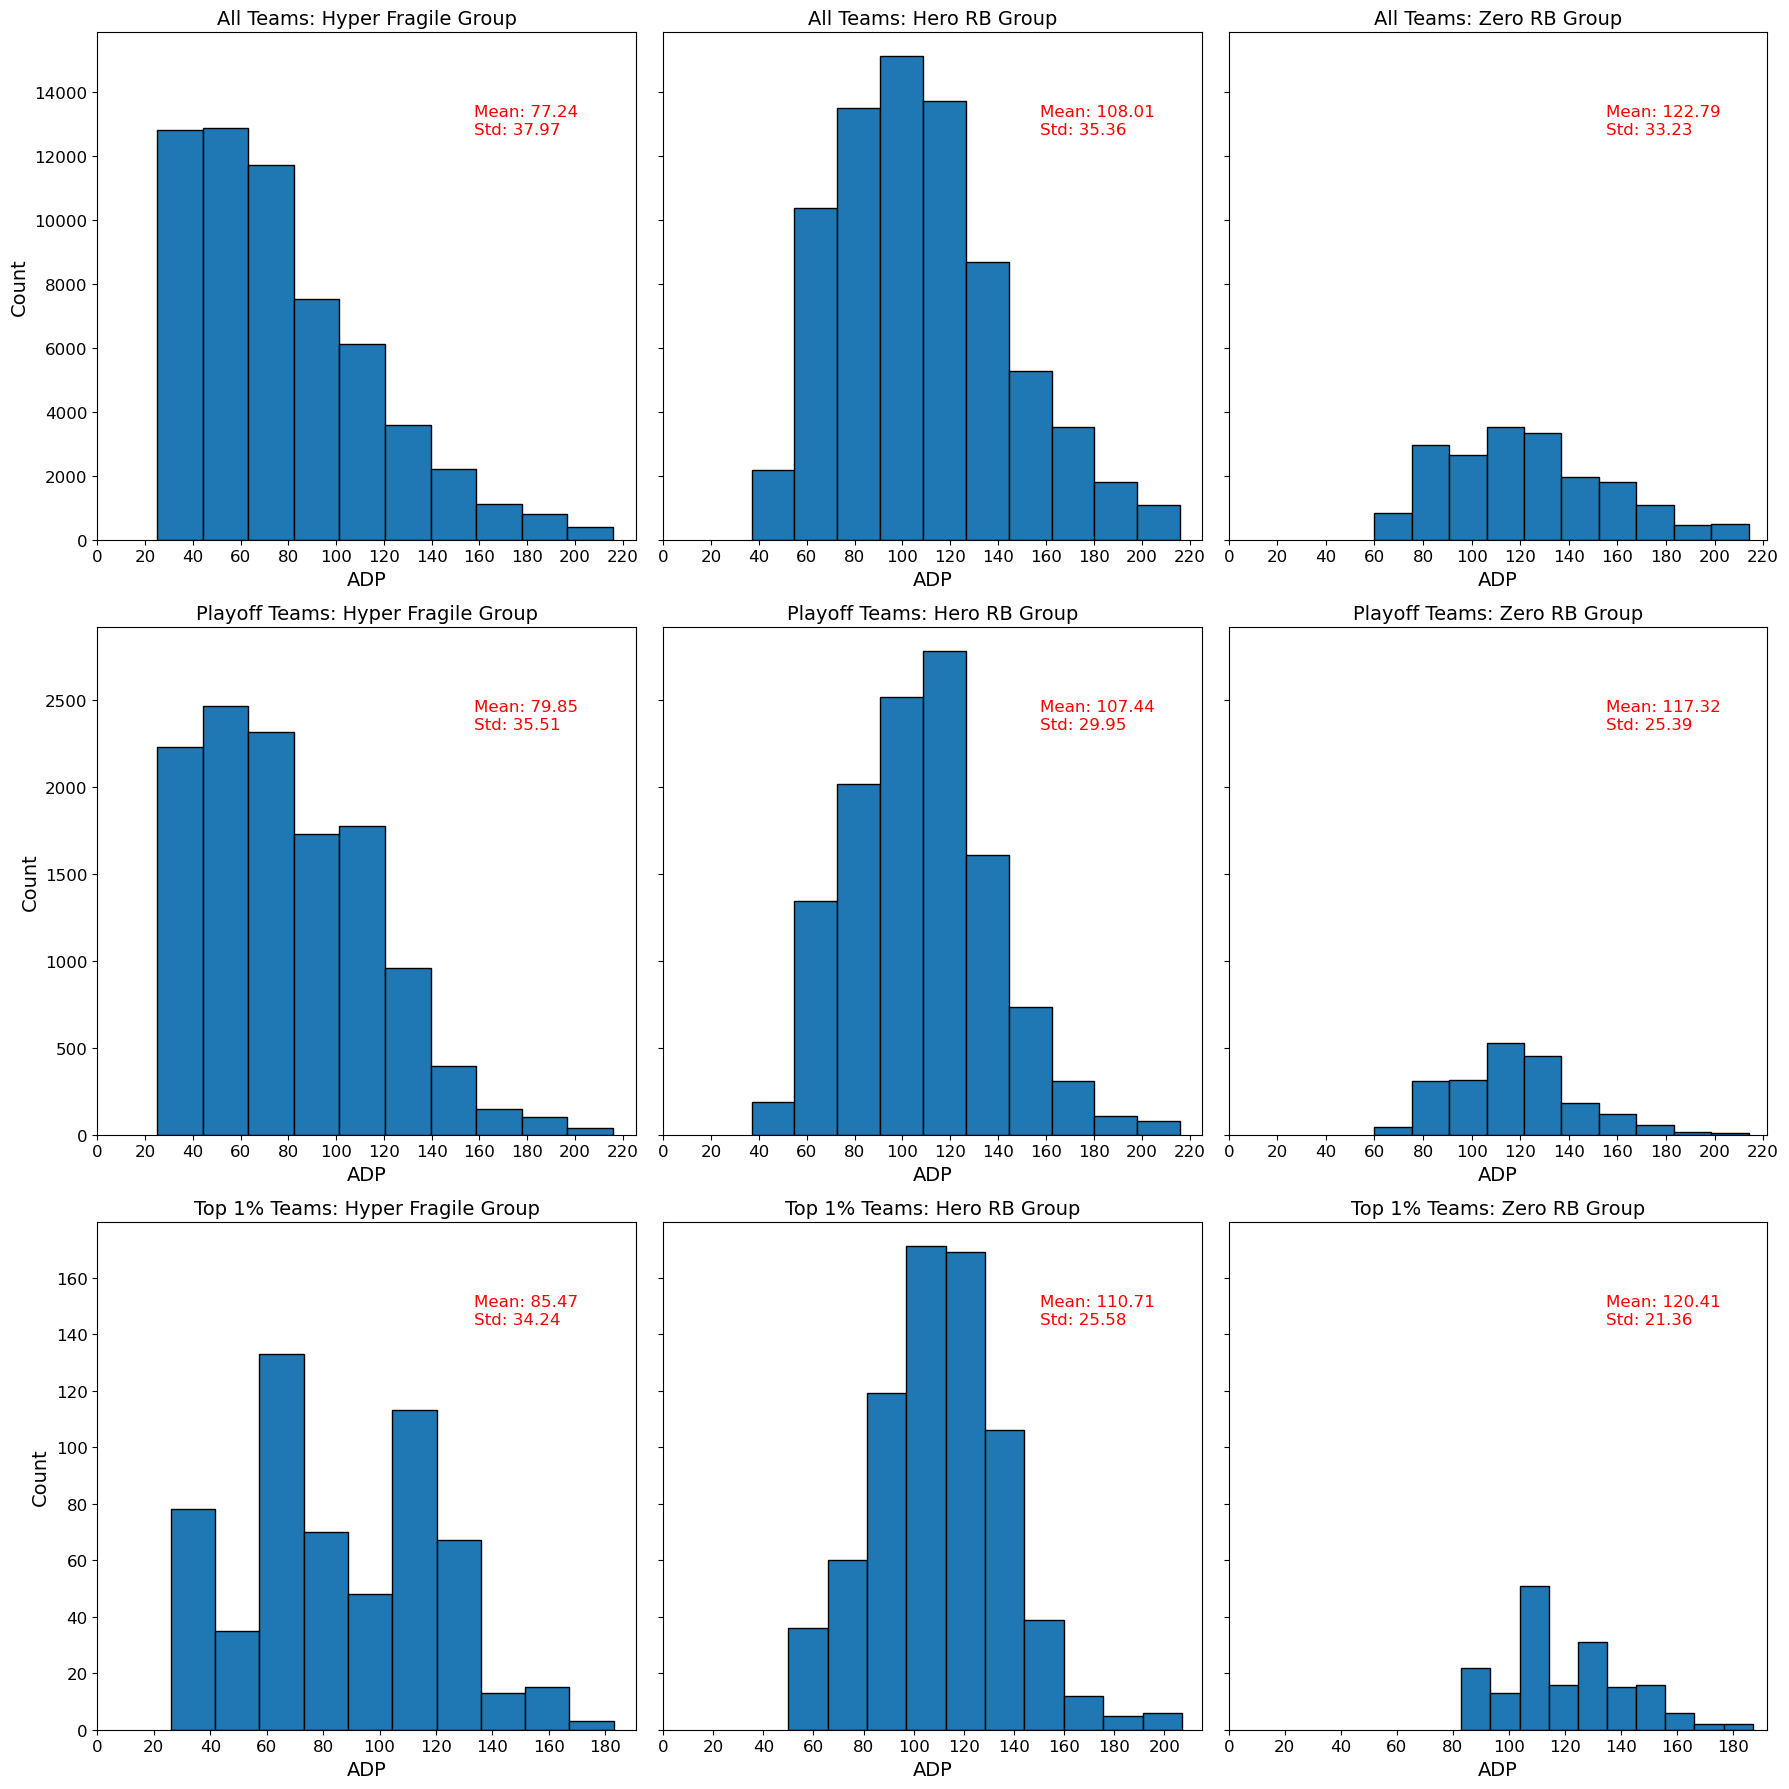

In [14]:
datasets = [all_teams2021, playoff_teams2021, top_1_percent2021_teams]
dataset_names = ['All Teams', 'Playoff Teams', 'Top 1% Teams']
group_types = ['Hyper Fragile', 'Hero RB', 'Zero RB']
fig, axs = plt.subplots(3, 3, figsize=(18, 18), sharey='row')
for i, data in enumerate(datasets):
    for j, group_type in enumerate(group_types):
        group_data = data[data['group_type'] == group_type]
        third_rb = group_data[group_data['order_taken'] == 3]
        axs[i, j].hist(third_rb['overall_pick_number'], bins=10, edgecolor='black')
        axs[i, j].set_title(f'{dataset_names[i]}: {group_type} Group', fontsize=14)
        max_adp = third_rb['overall_pick_number'].max()
        axs[i, j].set_xticks(np.arange(0, max_adp + 10, 20))
        mean_adp = third_rb['overall_pick_number'].mean()
        std_adp = third_rb['overall_pick_number'].std()
        axs[i, j].text(0.7, 0.8, f'Mean: {mean_adp:.2f}\nStd: {std_adp:.2f}', transform=axs[i, j].transAxes, fontsize=12, color='red')
        axs[i, j].tick_params(axis='both', which='major', labelsize=12)
for ax in axs.flat:
    ax.set_xlabel('ADP', fontsize=14)
for ax in axs[:, 0]:
    ax.set_ylabel('Count', fontsize=14)
plt.tight_layout()
plt.show()

The overall trend from the 2021 third RB pick number data is that it was better to draft your third RB later than the average drafter in 2021. I think an interesting result versus my expectation was how early the hyper fragile third RB was taken. One might think if you draft your first two RB within the first 36 picks that you can and should wait till a lot later but that wasn't really the case.

## 2022 Third RB Pick Number Data

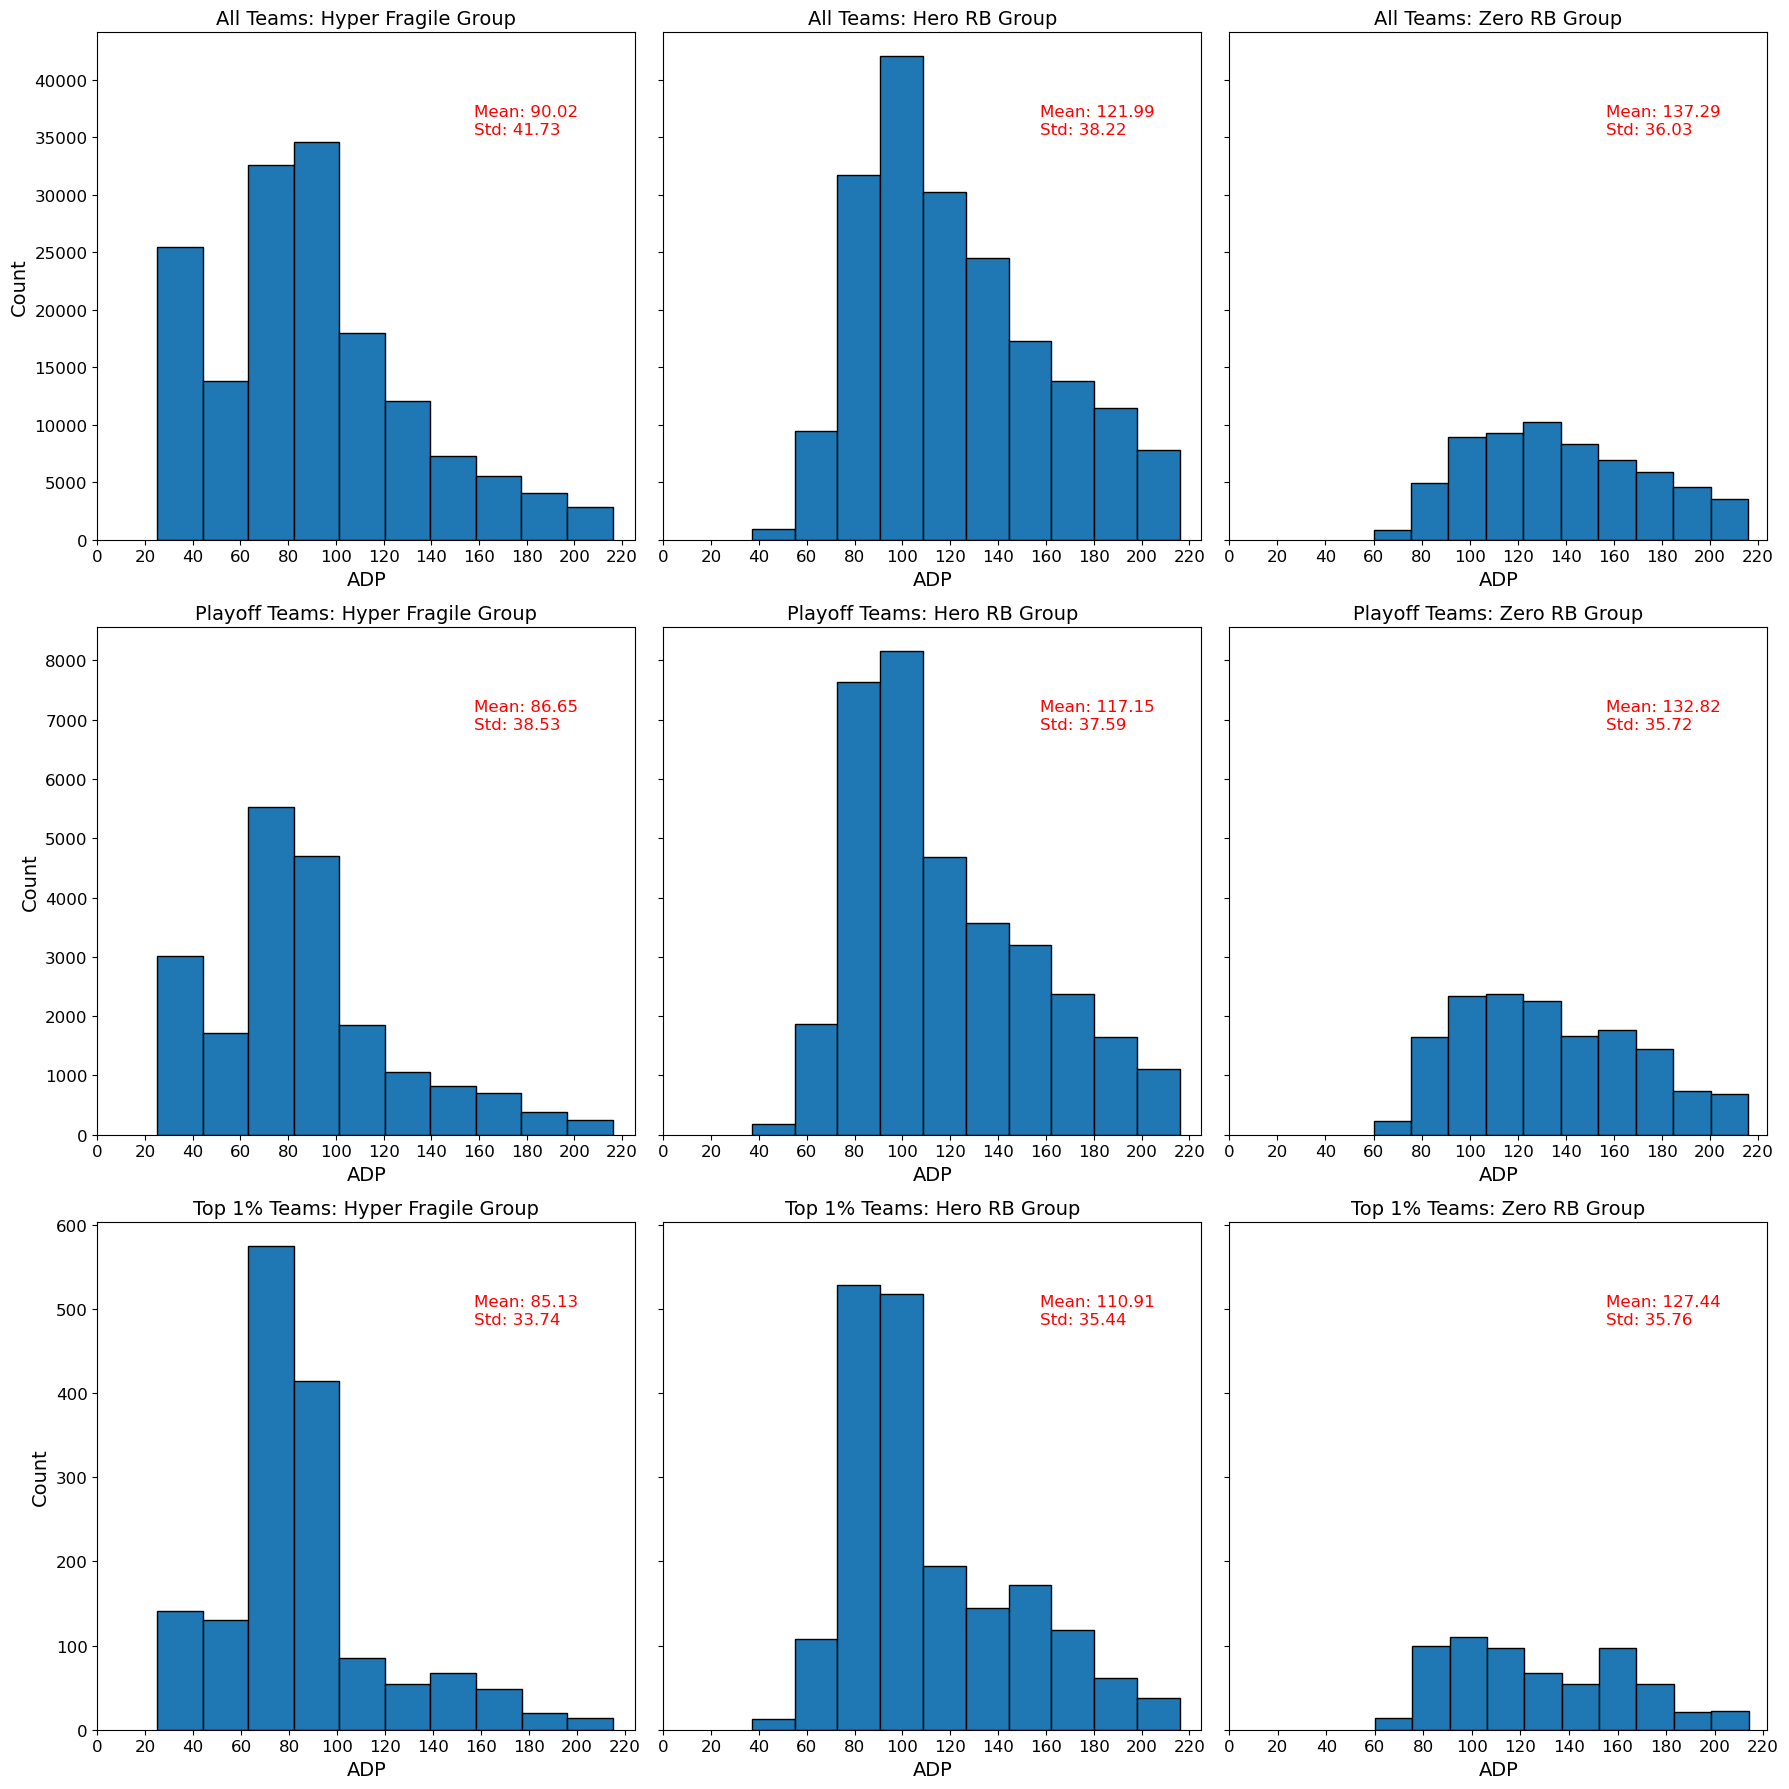

In [15]:
datasets = [all_teams2022, playoff_teams2022, top_1_percent2022_teams]
dataset_names = ['All Teams', 'Playoff Teams', 'Top 1% Teams']
group_types = ['Hyper Fragile', 'Hero RB', 'Zero RB']
fig, axs = plt.subplots(3, 3, figsize=(18, 18), sharey='row')
for i, data in enumerate(datasets):
    for j, group_type in enumerate(group_types):
        group_data = data[data['group_type'] == group_type]
        third_rb = group_data[group_data['order_taken'] == 3]
        axs[i, j].hist(third_rb['overall_pick_number'], bins=10, edgecolor='black')
        axs[i, j].set_title(f'{dataset_names[i]}: {group_type} Group', fontsize=14)
        max_adp = third_rb['overall_pick_number'].max()
        axs[i, j].set_xticks(np.arange(0, max_adp + 10, 20))
        mean_adp = third_rb['overall_pick_number'].mean()
        std_adp = third_rb['overall_pick_number'].std()
        axs[i, j].text(0.7, 0.8, f'Mean: {mean_adp:.2f}\nStd: {std_adp:.2f}', transform=axs[i, j].transAxes, fontsize=12, color='red')
        axs[i, j].tick_params(axis='both', which='major', labelsize=12)
for ax in axs.flat:
    ax.set_xlabel('ADP', fontsize=14)
for ax in axs[:, 0]:
    ax.set_ylabel('Count', fontsize=14)
plt.tight_layout()
plt.show()

It seemed that the exact opposite trend compared to 2021 occured. In 2022 picking your third RB earlier than the mean was the better strategy. The mean decreasing means that those teams that went later faded off and didn't make the cut of playoff teams or top 1 percent teams. However, the other trend of picking your third hyper fragile RB pretty early around pick 85 remained the same. 

## 2021 4th Running Back Pick Number 

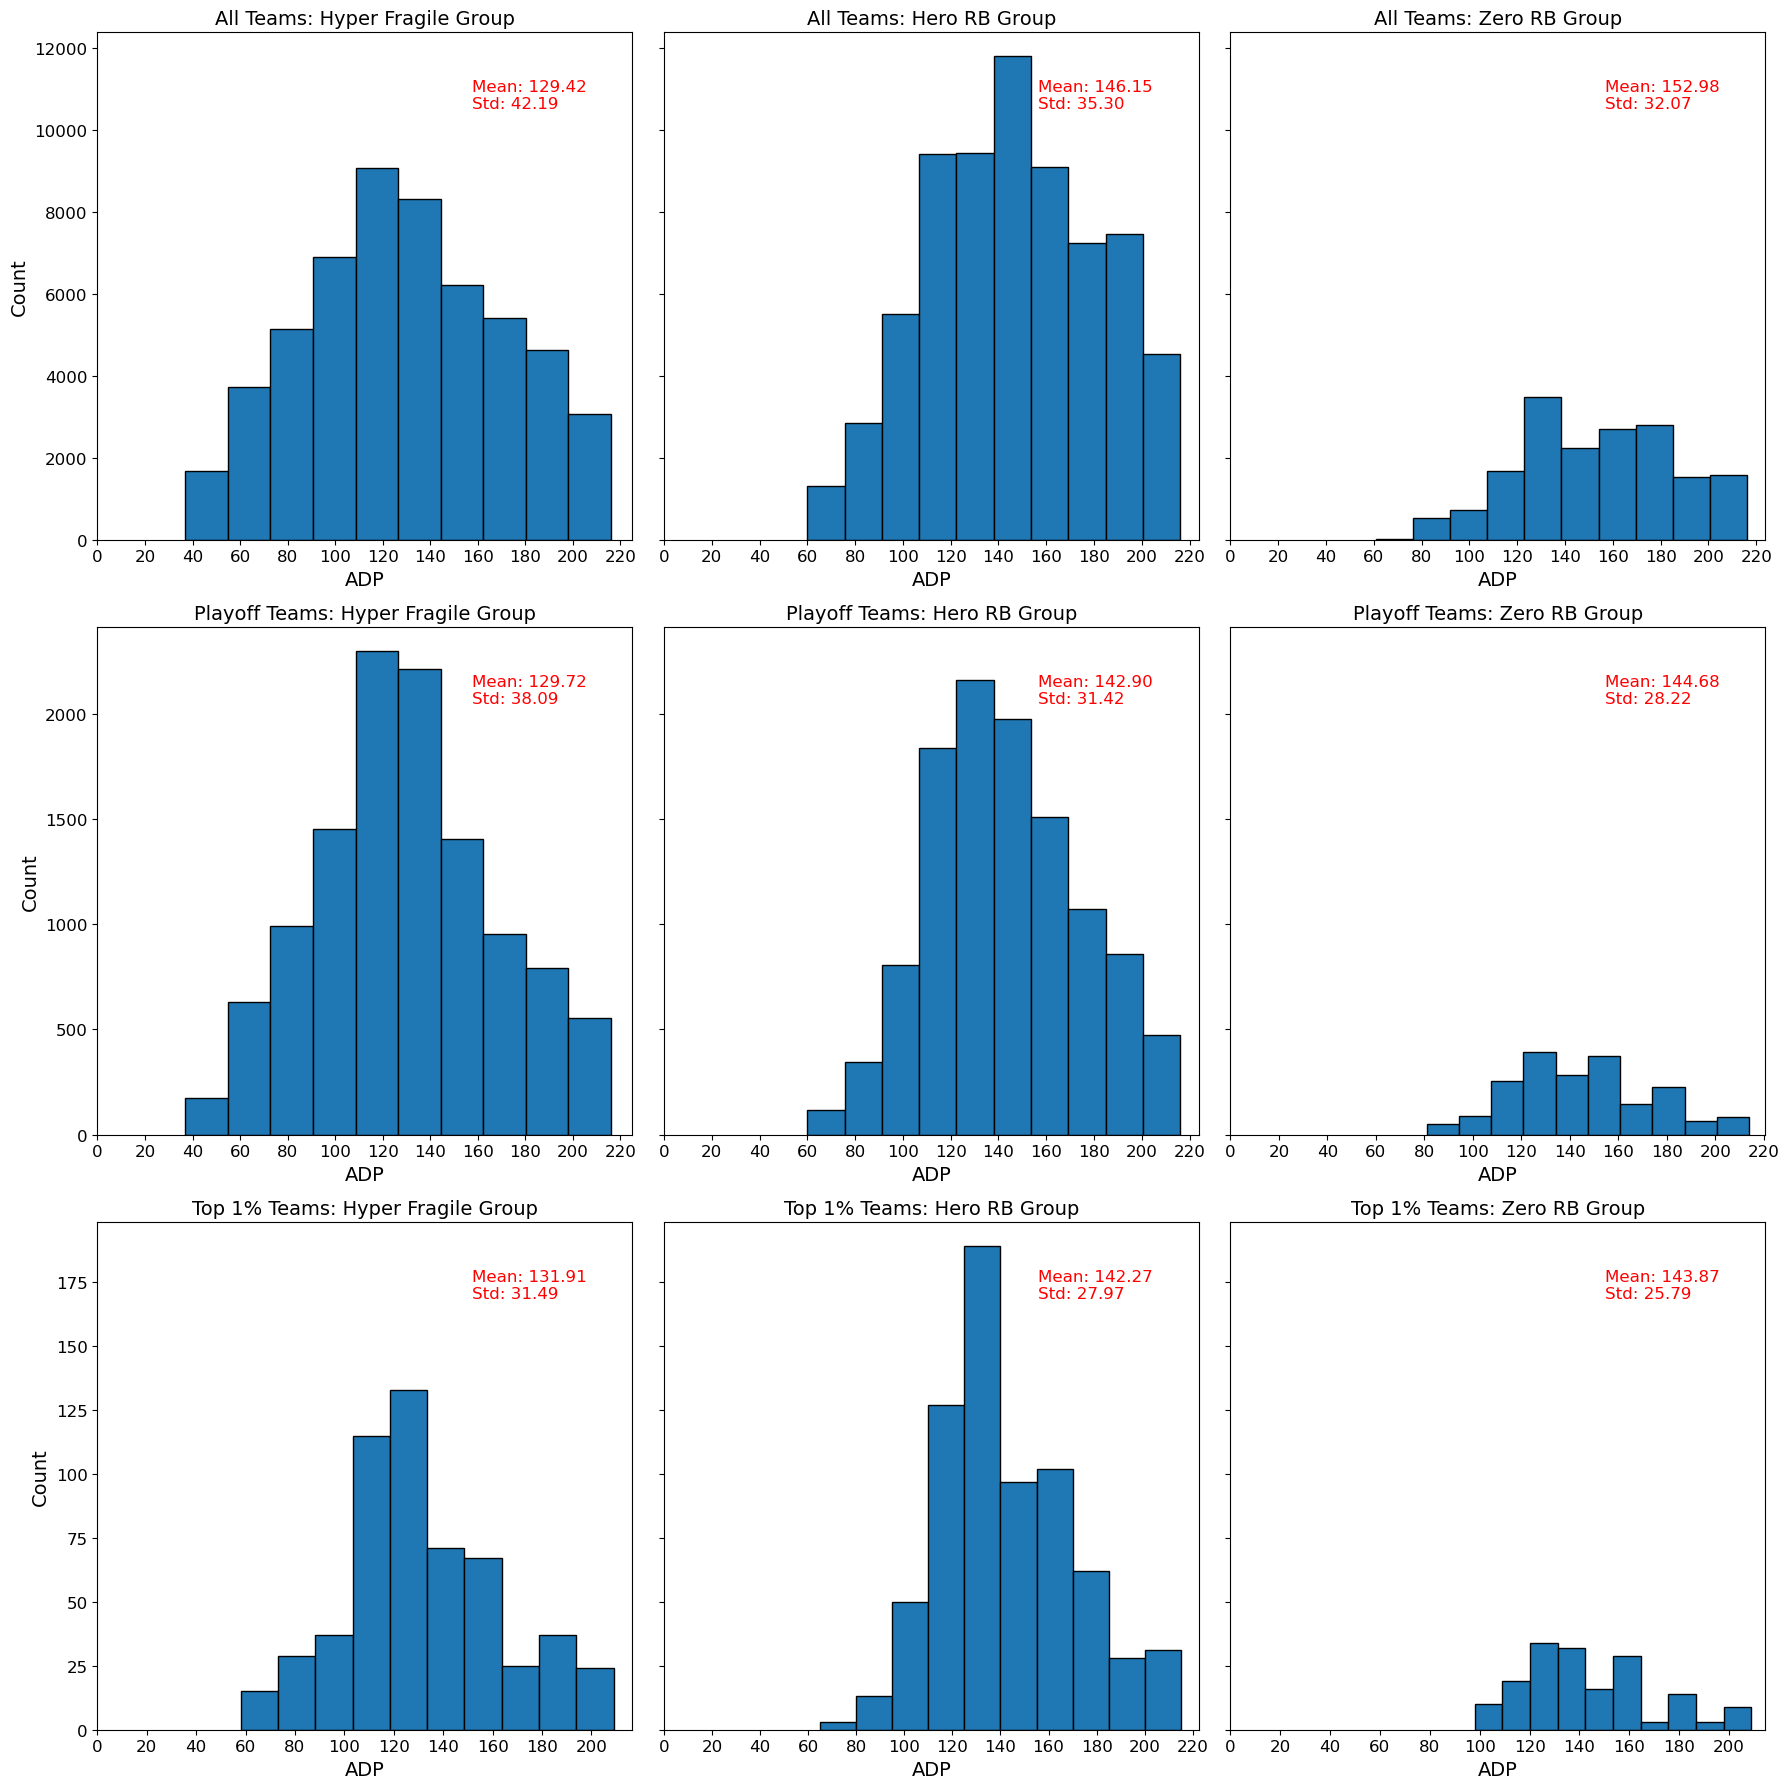

In [18]:
datasets = [all_teams2021, playoff_teams2021, top_1_percent2021_teams]
dataset_names = ['All Teams', 'Playoff Teams', 'Top 1% Teams']
group_types = ['Hyper Fragile', 'Hero RB', 'Zero RB']
fig, axs = plt.subplots(3, 3, figsize=(18, 18), sharey='row')
for i, data in enumerate(datasets):
    for j, group_type in enumerate(group_types):
        group_data = data[data['group_type'] == group_type]
        fourth_rb = group_data[group_data['order_taken'] == 4]
        axs[i, j].hist(fourth_rb['overall_pick_number'], bins=10, edgecolor='black')
        axs[i, j].set_title(f'{dataset_names[i]}: {group_type} Group', fontsize=14)
        max_adp = fourth_rb['overall_pick_number'].max()
        axs[i, j].set_xticks(np.arange(0, max_adp + 10, 20))
        mean_adp = fourth_rb['overall_pick_number'].mean()
        std_adp = fourth_rb['overall_pick_number'].std()
        axs[i, j].text(0.7, 0.85, f'Mean: {mean_adp:.2f}\nStd: {std_adp:.2f}', transform=axs[i, j].transAxes, fontsize=12, color='red')
        axs[i, j].tick_params(axis='both', which='major', labelsize=12)
for ax in axs.flat:
    ax.set_xlabel('ADP', fontsize=14)
for ax in axs[:, 0]:
    ax.set_ylabel('Count', fontsize=14)
plt.tight_layout()
plt.show()

Not much change between the playoff, top 1% and all teams in Hyper Fragile and Hero but with the Zero RB teams it was definitely better to draft your fourth RB earlier and I think this can be correlated to Hayden Wink's idea that gets highlighted by Pat Kerrane a lot of needing to draft 4 RBs through no later than round 13. This data definitely proves that because the thirteenth round ends at pick 156. The only subset that has a mean reasonably close to that number was all teams Zero RB which saw a decrease among the playoff and top 1% teams.

## 2022 4th Running Back Pick Number

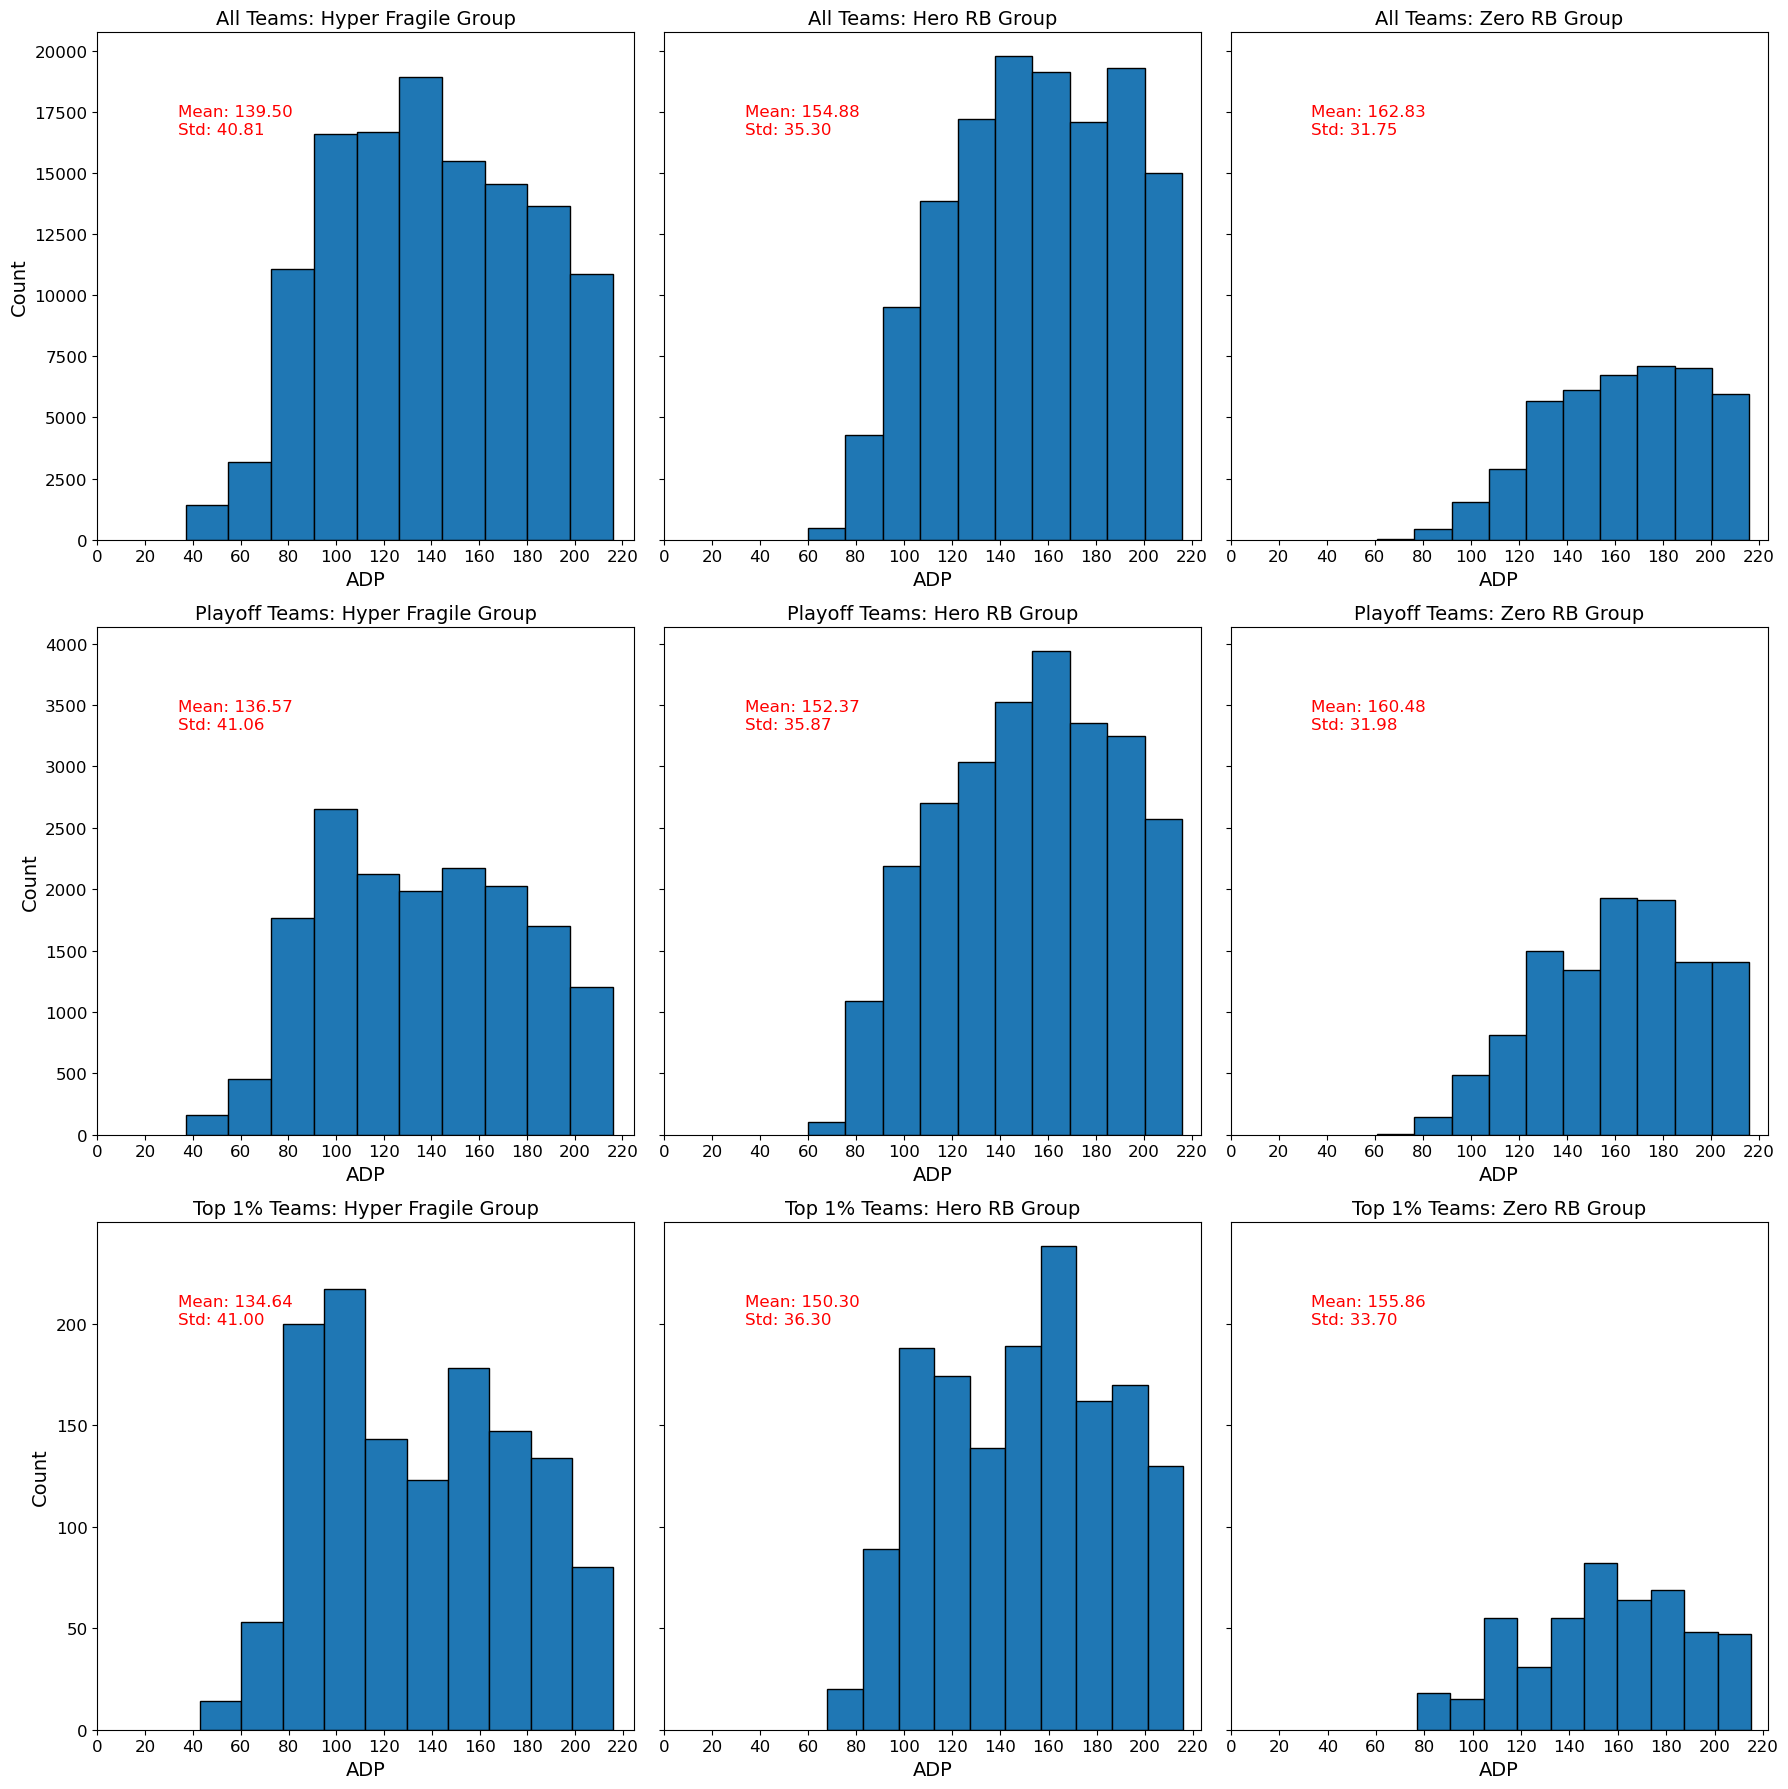

In [19]:
datasets = [all_teams2022, playoff_teams2022, top_1_percent2022_teams]
dataset_names = ['All Teams', 'Playoff Teams', 'Top 1% Teams']
group_types = ['Hyper Fragile', 'Hero RB', 'Zero RB']
fig, axs = plt.subplots(3, 3, figsize=(18, 18), sharey='row')
for i, data in enumerate(datasets):
    for j, group_type in enumerate(group_types):      
        group_data = data[data['group_type'] == group_type]
        fourth_rb = group_data[group_data['order_taken'] == 4]
        axs[i, j].hist(fourth_rb['overall_pick_number'], bins=10, edgecolor='black')
        axs[i, j].set_title(f'{dataset_names[i]}: {group_type} Group', fontsize=14)
        max_adp = fourth_rb['overall_pick_number'].max()
        axs[i, j].set_xticks(np.arange(0, max_adp + 10, 20))
        mean_adp = fourth_rb['overall_pick_number'].mean()
        std_adp = fourth_rb['overall_pick_number'].std()
        axs[i, j].text(0.15, 0.8, f'Mean: {mean_adp:.2f}\nStd: {std_adp:.2f}', transform=axs[i, j].transAxes, fontsize=12, color='red')
        axs[i, j].tick_params(axis='both', which='major', labelsize=12)
for ax in axs.flat:
    ax.set_xlabel('ADP', fontsize=14)
for ax in axs[:, 0]:
    ax.set_ylabel('Count', fontsize=14)
plt.tight_layout()
plt.show()

In 2022 it was better to draft the fourth RB below the mean of all teams for every type of structure. This Hayden Wink's idea of drafting 4 running backs through 13 rounds can be seen here again as this time there are multiple subset at or near 156 but each one of them ended up decreasing in the top 1% of teams

## The Upper and Lower Bounds of Top 1% Teams by Structure

In [20]:
bounds_df = pd.DataFrame(columns=["Group Type", "Order Taken", "Lower Bound", "Upper Bound"])
index = 0
group_types = ['Hyper Fragile', 'Hero RB', 'Zero RB']
datasets = [top_1_percent2021_teams, top_1_percent2022_teams]
for order_taken in [3, 4]: 
    for group_type in group_types:
        for i, data in enumerate(datasets):
            group_data = data[data['group_type'] == group_type]
            rb_data = group_data[group_data['order_taken'] == order_taken]
            Q1 = rb_data['overall_pick_number'].quantile(0.25)
            Q3 = rb_data['overall_pick_number'].quantile(0.75)
            low_guardrail = ((Q1))
            high_guardrail = ((Q3))
            bounds_df.loc[index] = [group_type, order_taken, low_guardrail, high_guardrail]
            index += 1           
guardrails = bounds_df.groupby(['Group Type', 'Order Taken']).mean().reset_index()
print(guardrails)

      Group Type  Order Taken  Lower Bound  Upper Bound
0        Hero RB            3         89.5       130.75
1        Hero RB            4        121.5       169.50
2  Hyper Fragile            3         64.0       102.50
3  Hyper Fragile            4        104.5       160.50
4        Zero RB            3        102.5       145.50
5        Zero RB            4        130.0       170.50


The code above creates 25% and 75% bounds for the top 1 percent of teams based on the order taken of the running back and which structure the team was in. It then averages the 2021 bounds with the 2022 bounds.

## 2021 3rd RB Archetype

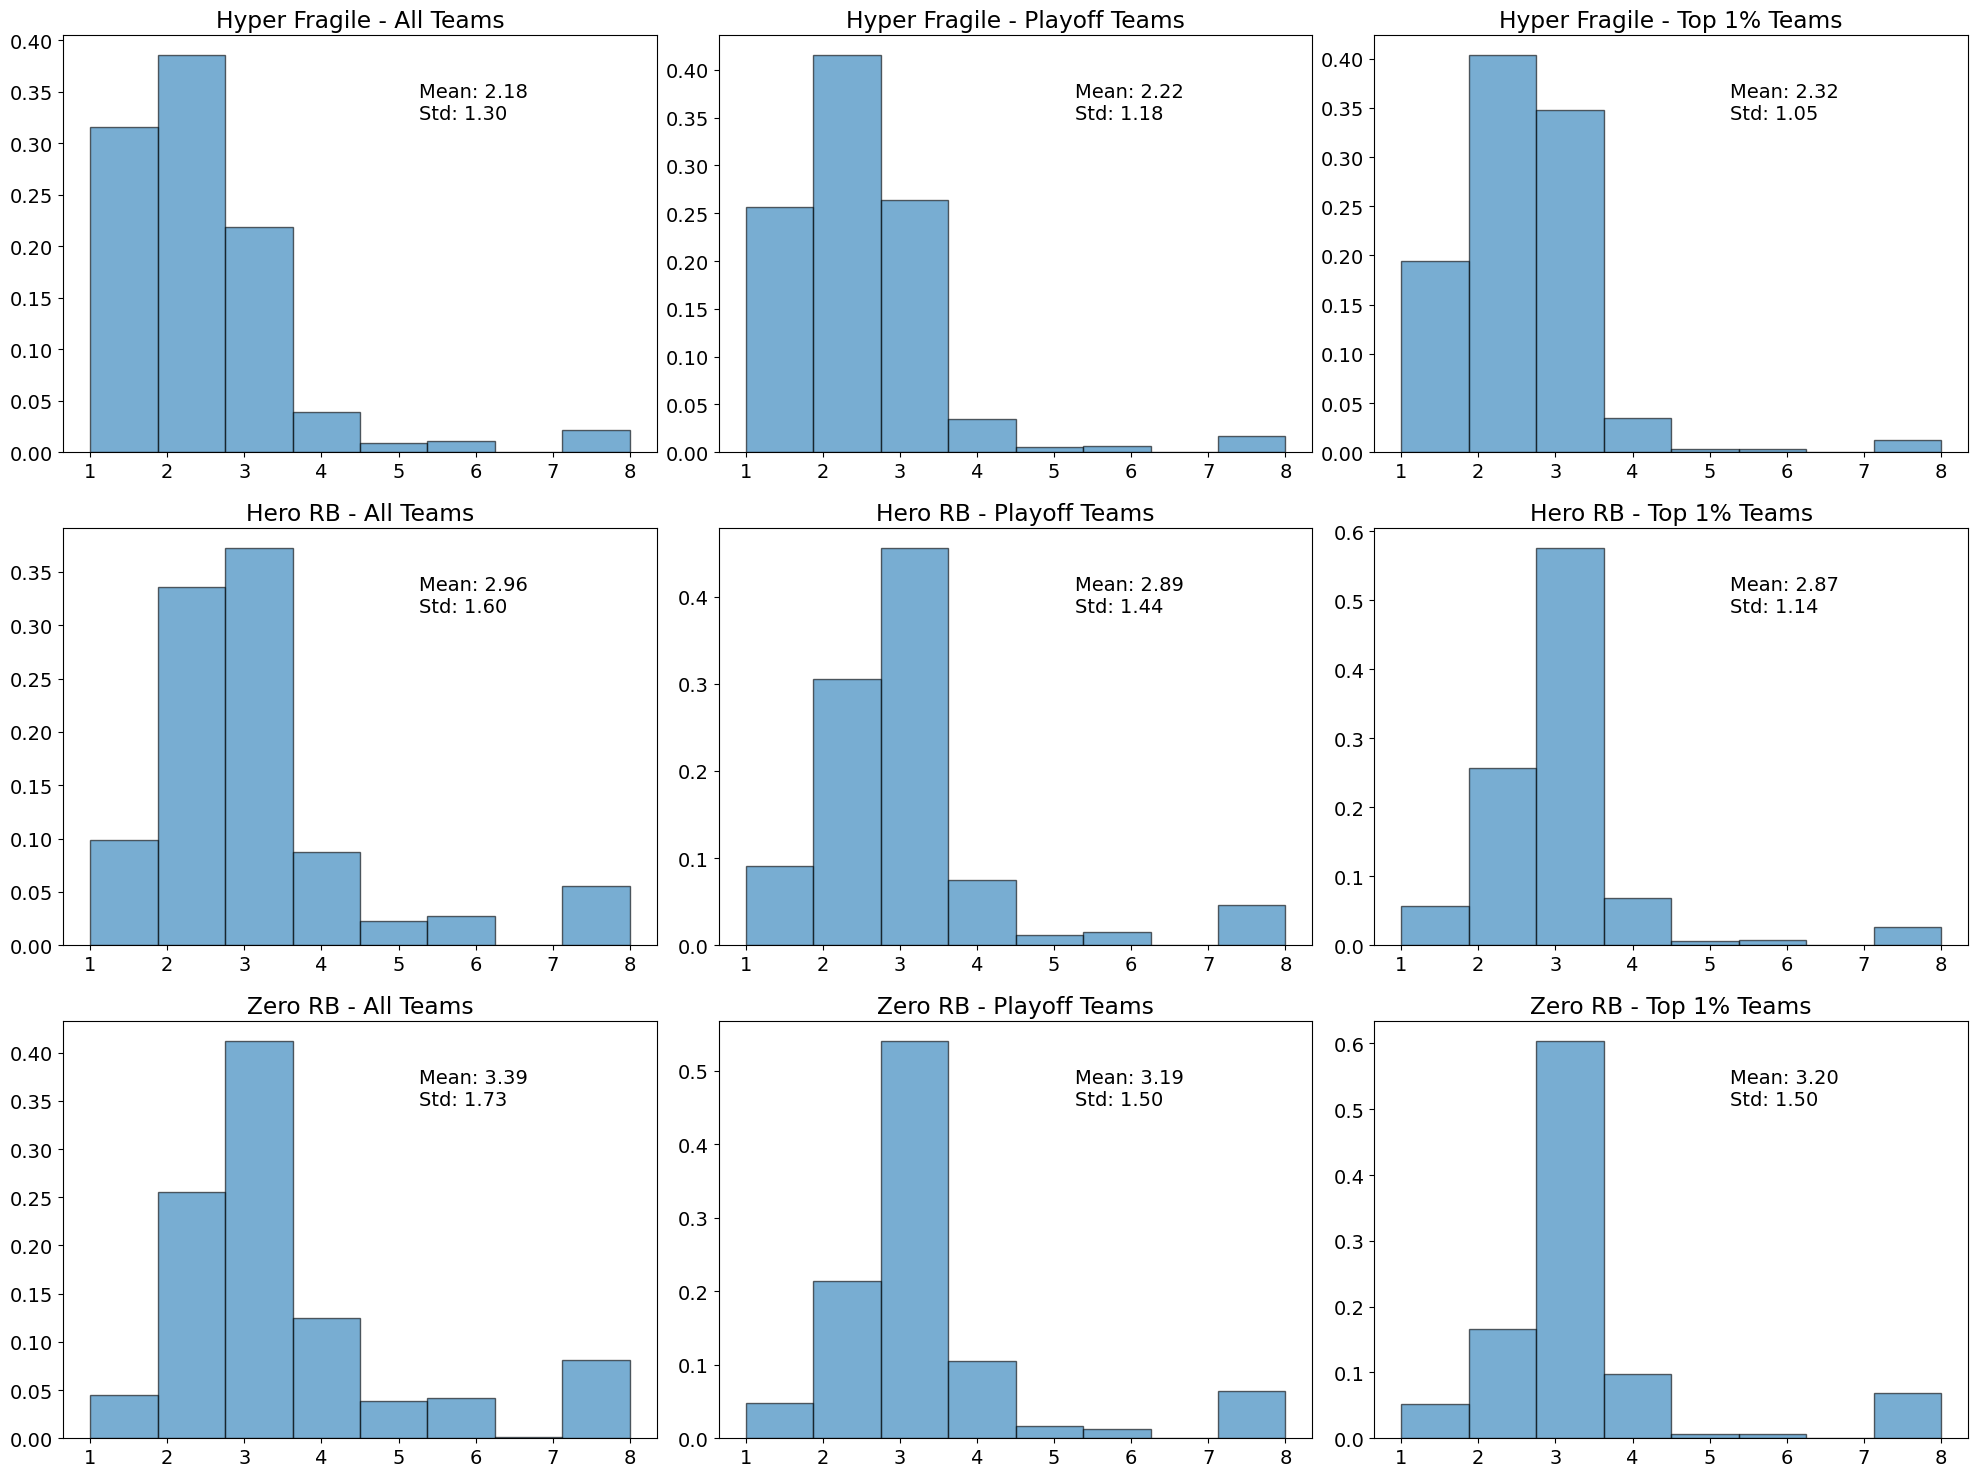

In [21]:
plt.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(3, 3, figsize=(20, 15))
group_types = ['Hyper Fragile', 'Hero RB', 'Zero RB']
datasets = [all_teams2021, playoff_teams2021, top_1_percent2021_teams]
dataset_names = ['All Teams', 'Playoff Teams', 'Top 1% Teams']
for i, group_type in enumerate(group_types):
    for j, dataset in enumerate(datasets):
        data = dataset[(dataset['group_type'] == group_type) & (dataset['order_taken'] == 3) & (dataset['archetype'] >= 1)]
        weights = np.ones_like(data['archetype']) / len(data['archetype'])
        axs[i, j].hist(data['archetype'], bins=8, edgecolor='black', alpha=0.6, weights=weights)
        axs[i, j].set_title(f'{group_type} - {dataset_names[j]}')
        axs[i, j].text(0.6, 0.8, f'Mean: {data["archetype"].mean():.2f}\nStd: {data["archetype"].std():.2f}', transform=axs[i, j].transAxes)
plt.tight_layout()
plt.show()

The one trend that pops out is that regardless of structure having a third RB with an archetype of three or less was a very common strategy. Also, as you go from all teams to playoff teams to top 1 percent teams, no matter the structure the archetype three was increasingly a higher percent of overall RB archetypes.

## 2022 3rd RB Archetype

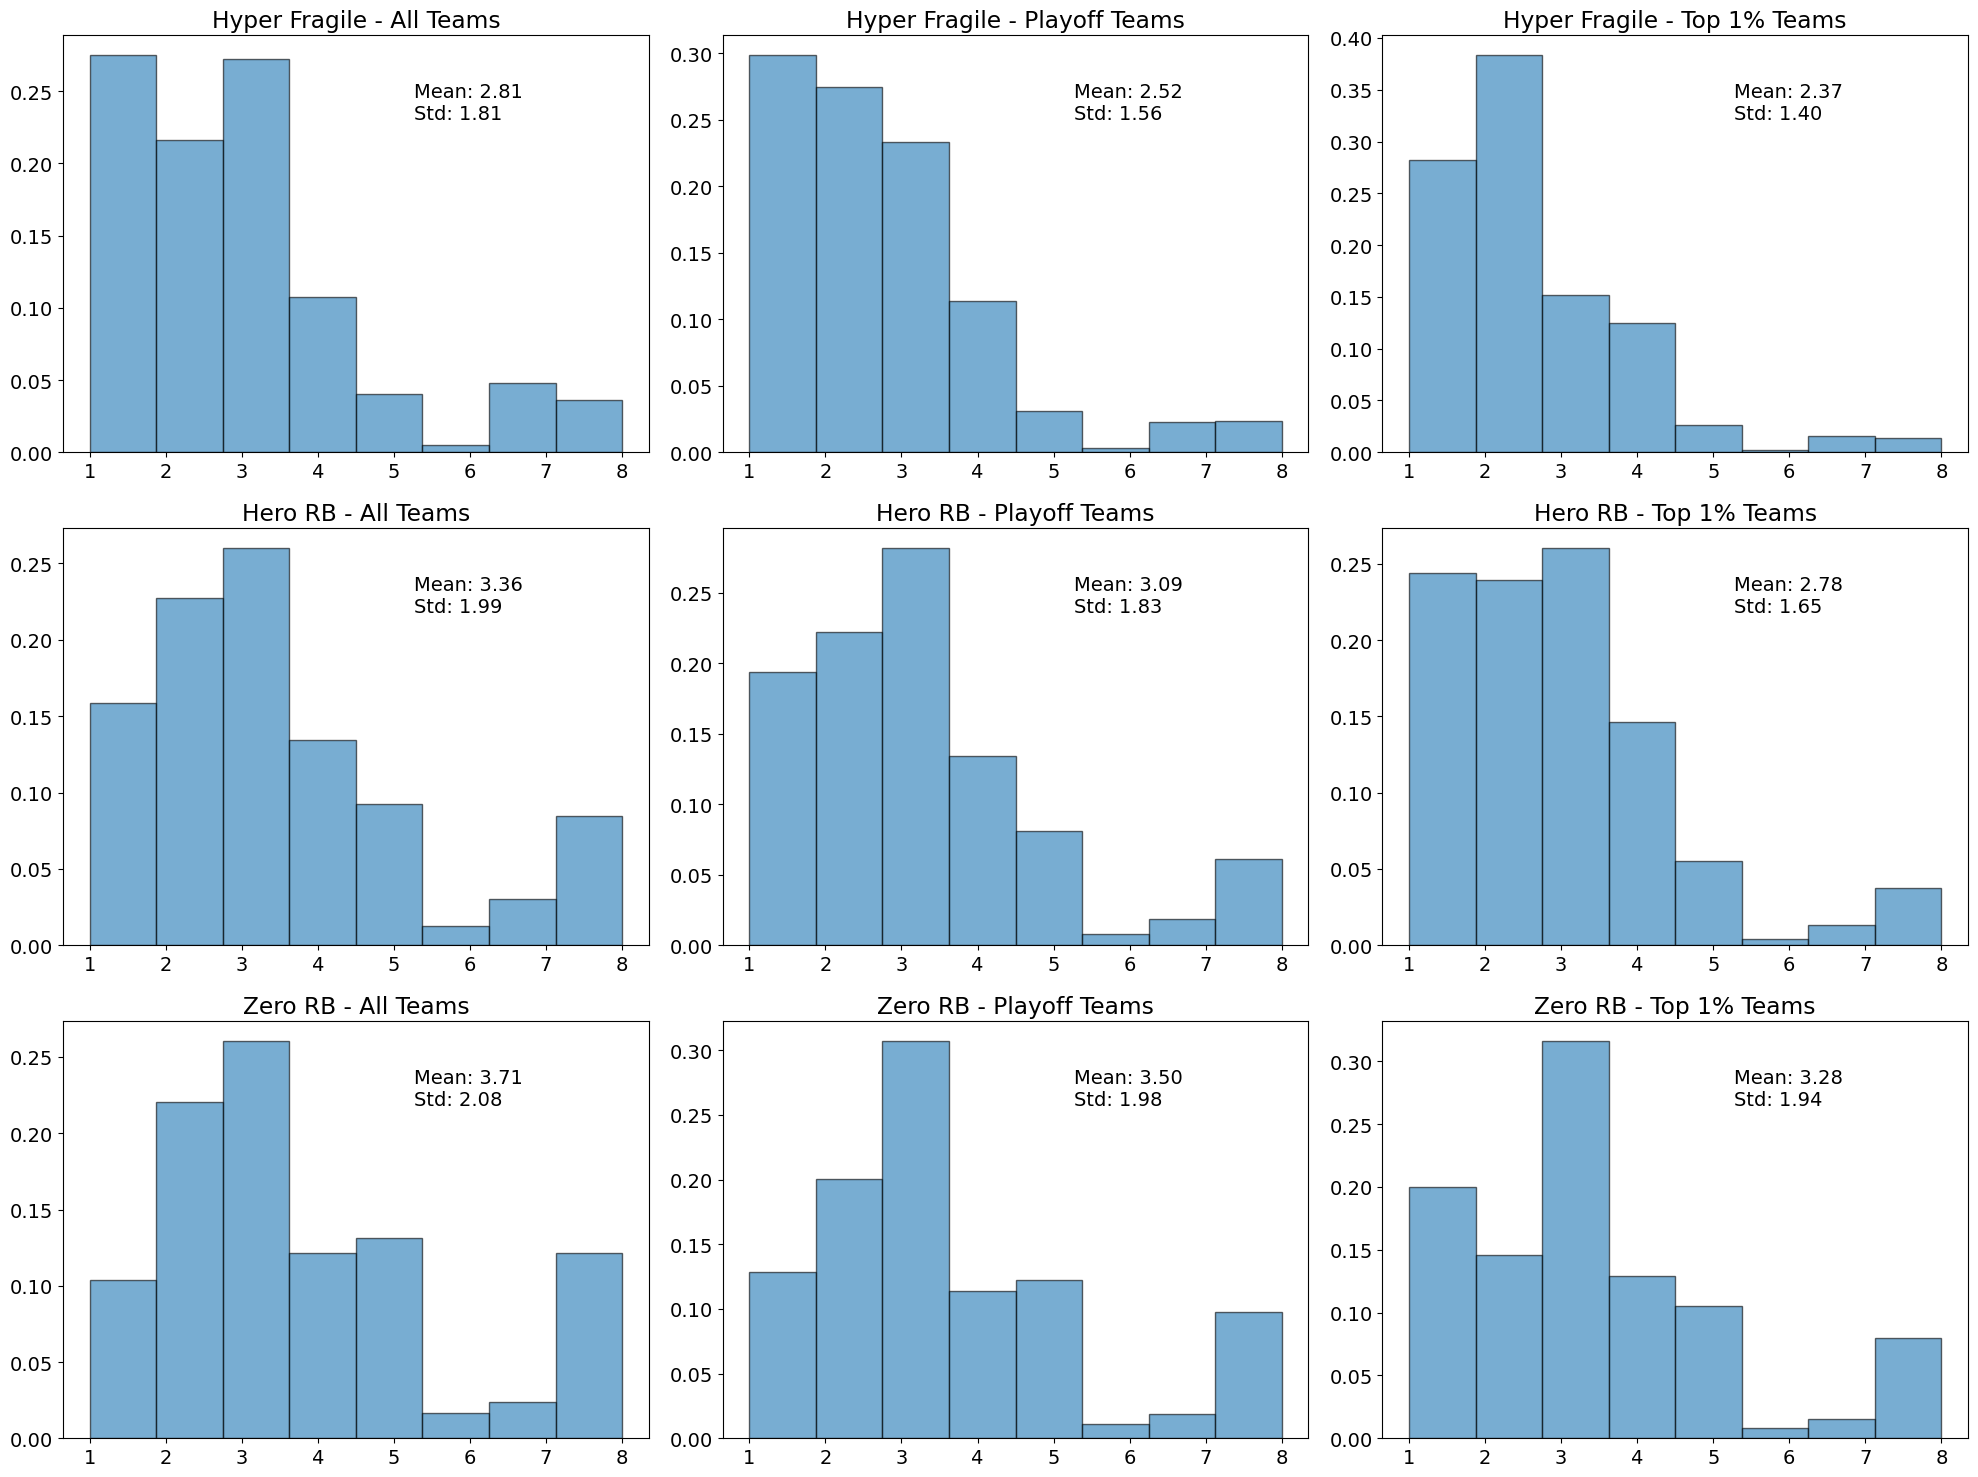

In [22]:
plt.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(3, 3, figsize=(20, 15))
group_types = ['Hyper Fragile', 'Hero RB', 'Zero RB']
datasets = [all_teams2022, playoff_teams2022, top_1_percent2022_teams]
dataset_names = ['All Teams', 'Playoff Teams', 'Top 1% Teams']
for i, group_type in enumerate(group_types):
    for j, dataset in enumerate(datasets):
        data = dataset[(dataset['group_type'] == group_type) & (dataset['order_taken'] == 3) & (dataset['archetype'] >= 1)]
        weights = np.ones_like(data['archetype']) / len(data['archetype'])
        axs[i, j].hist(data['archetype'], bins=8, edgecolor='black', alpha=0.6, weights=weights)
        axs[i, j].set_title(f'{group_type} - {dataset_names[j]}')
        axs[i, j].text(0.6, 0.8, f'Mean: {data["archetype"].mean():.2f}\nStd: {data["archetype"].std():.2f}', transform=axs[i, j].transAxes)
plt.tight_layout()
plt.show()

Two things stick out from the 2022 3rd RB Archetype Data: the increase of the archetype one in the Hero RB structure and the increase of the archetype two in the hyper fragile. The increase in the archtype one in the Hero RB structure makes a lot of sense, if you can get a RB that is a bellcow later than your competitors it is very easy to see how that can translate into a top 1% team. The increase of the archetype two in the hyper fragile is very interesting and I know a common strategy among drafters is take the cheaper guy in some of the ambigious backfields but I think this proves the point of really trying to mix both the archetype two and archetype three into your portfolio being a preferable strategy.

## 2021 4th RB Archetype

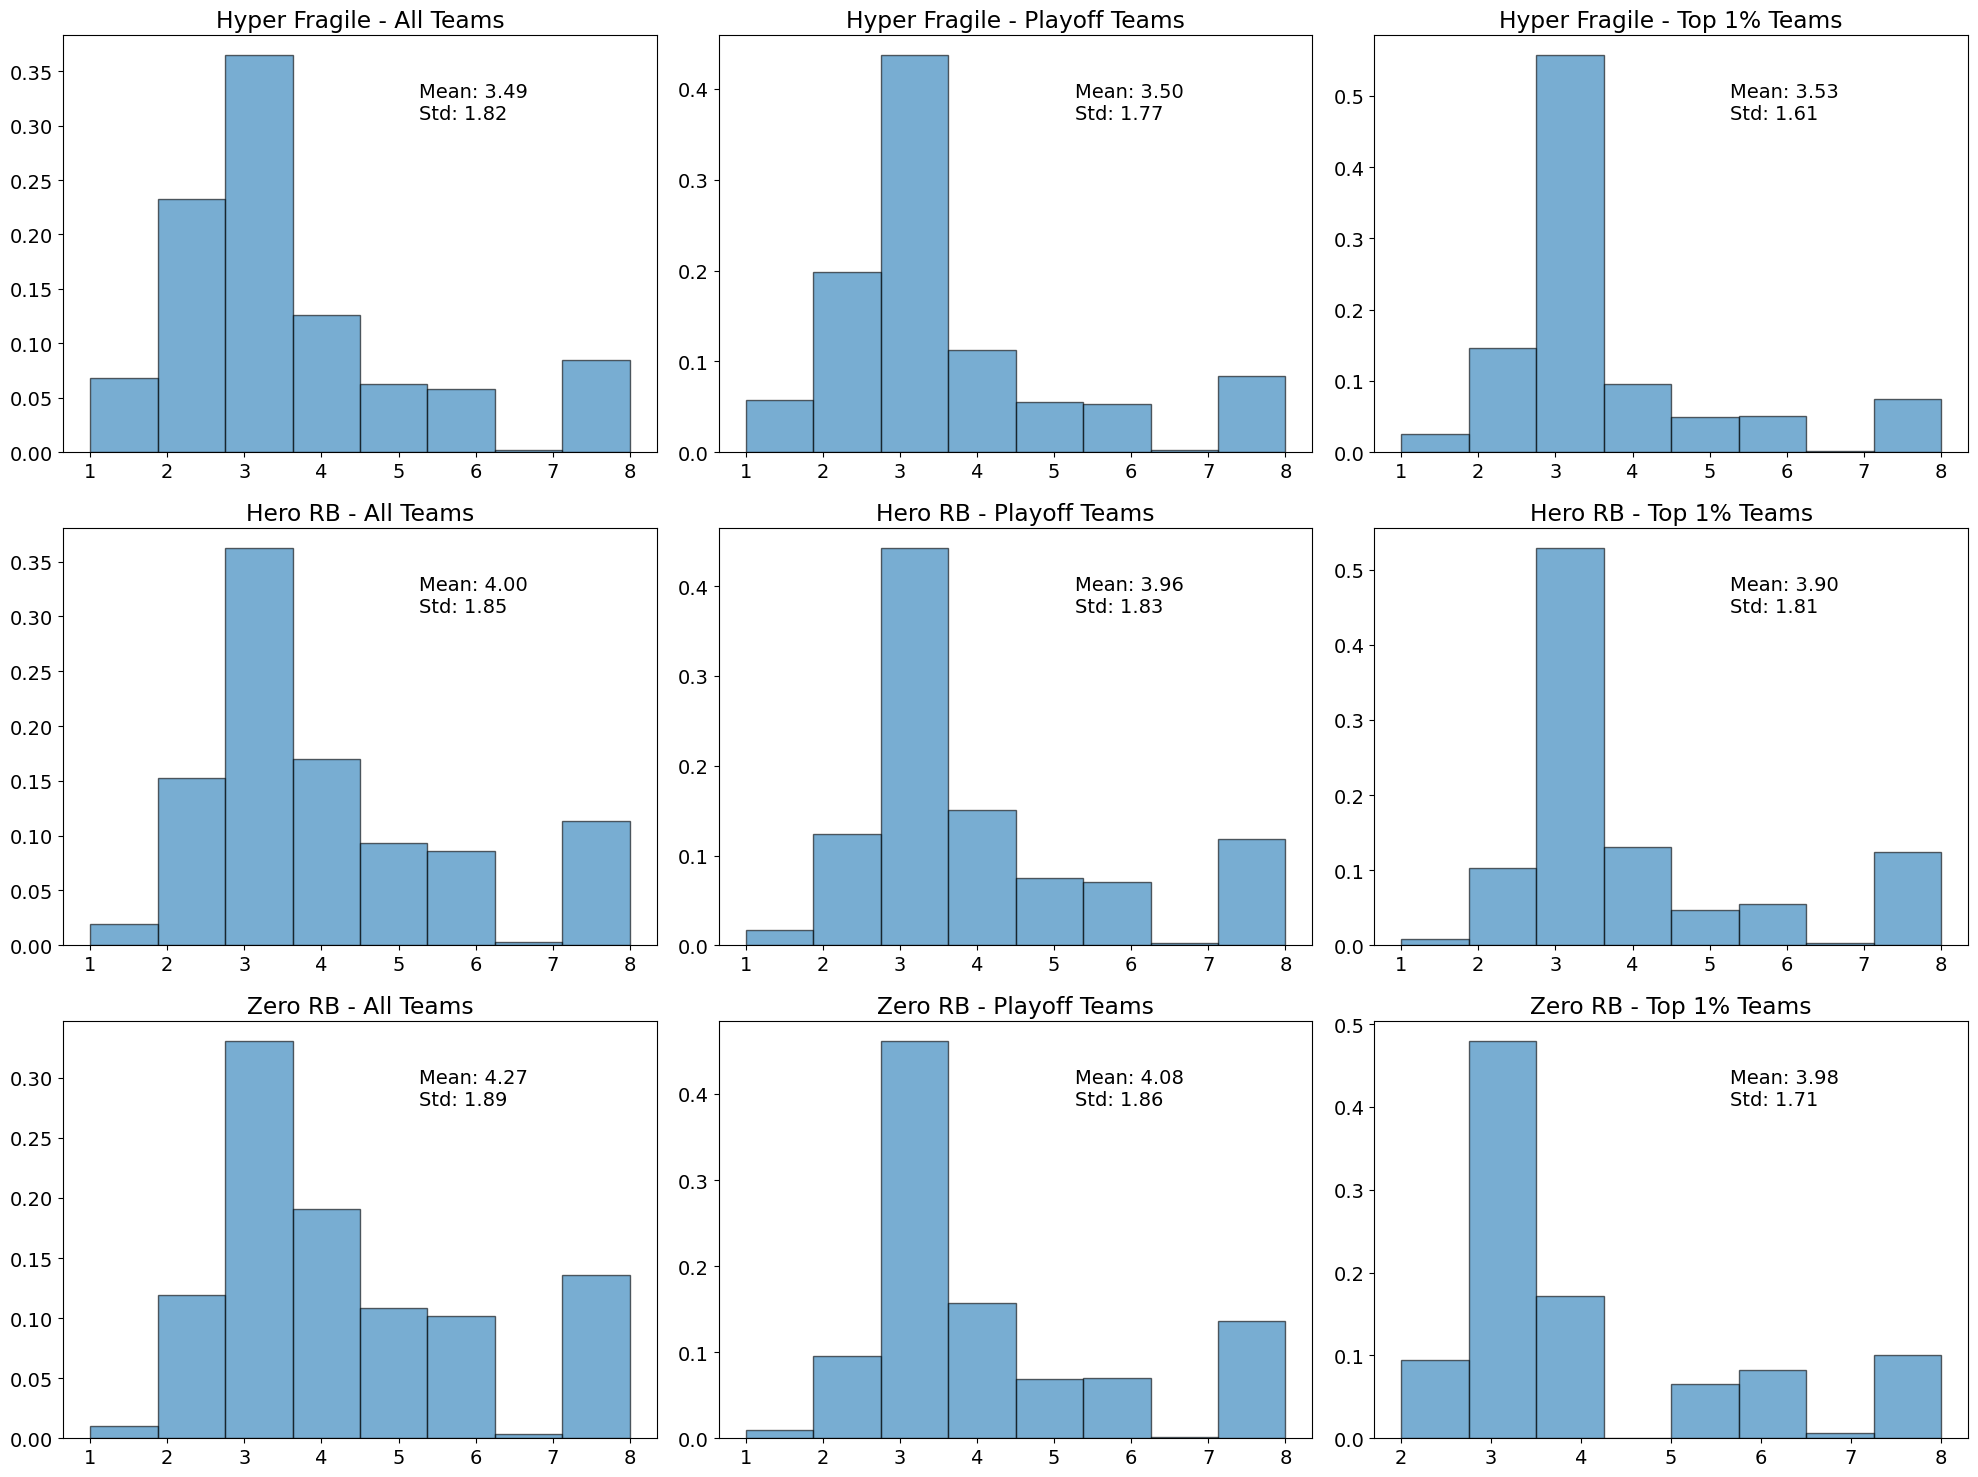

In [23]:
plt.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(3, 3, figsize=(20, 15))
group_types = ['Hyper Fragile', 'Hero RB', 'Zero RB']
datasets = [all_teams2021, playoff_teams2021, top_1_percent2021_teams]
dataset_names = ['All Teams', 'Playoff Teams', 'Top 1% Teams']
for i, group_type in enumerate(group_types):
    for j, dataset in enumerate(datasets):
        data = dataset[(dataset['group_type'] == group_type) & (dataset['order_taken'] == 4) & (dataset['archetype'] >= 1)]
        weights = np.ones_like(data['archetype']) / len(data['archetype'])
        axs[i, j].hist(data['archetype'], bins=8, edgecolor='black', alpha=0.6, weights=weights)
        axs[i, j].set_title(f'{group_type} - {dataset_names[j]}')
        axs[i, j].text(0.6, 0.8, f'Mean: {data["archetype"].mean():.2f}\nStd: {data["archetype"].std():.2f}', transform=axs[i, j].transAxes)
plt.tight_layout()
plt.show()

The one trend that seems consistent throughout the 2021 data is the archetype three being dominant. We see again the increase of archetype three throughout all structures as you go from all team to playoff teams to top 1 percent teams. I think there is sometimes a belief among some drafters that your fourth RB will never really see the light of the day and doesn't matter so just punt the position off and take it way later. The 2021 data would disagree heavily with that statement.

## 2022 4th RB Archetype

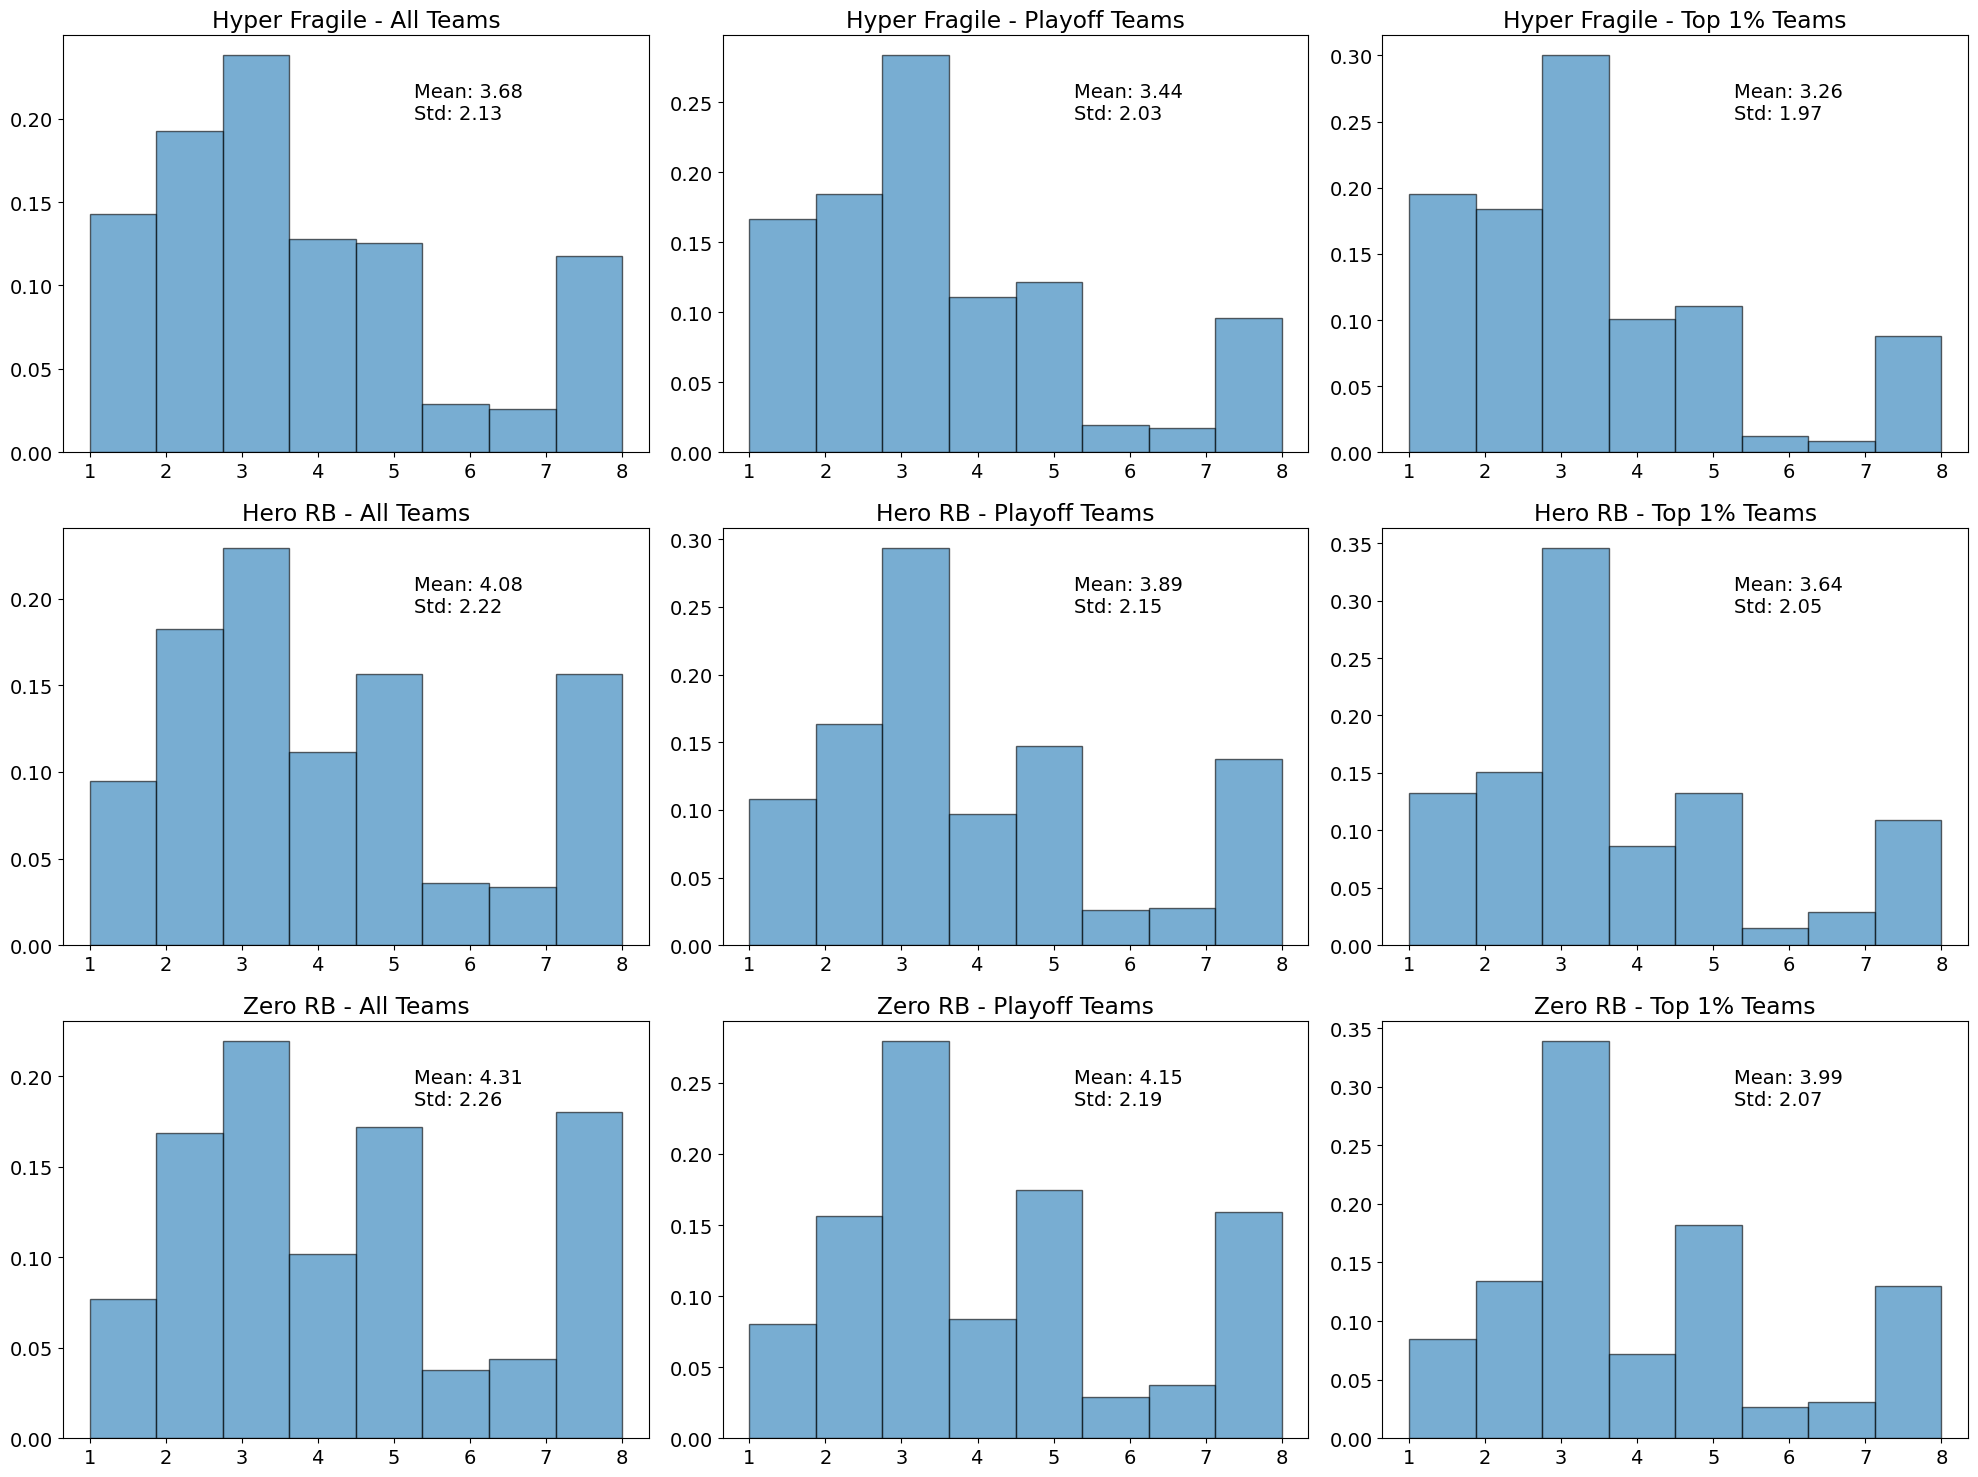

In [24]:
plt.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(3, 3, figsize=(20, 15))
group_types = ['Hyper Fragile', 'Hero RB', 'Zero RB']
datasets = [all_teams2022, playoff_teams2022, top_1_percent2022_teams]
dataset_names = ['All Teams', 'Playoff Teams', 'Top 1% Teams']
for i, group_type in enumerate(group_types):
    for j, dataset in enumerate(datasets):
        data = dataset[(dataset['group_type'] == group_type) & (dataset['order_taken'] == 4) & (dataset['archetype'] >= 1)]
        weights = np.ones_like(data['archetype']) / len(data['archetype'])
        axs[i, j].hist(data['archetype'], bins=8, edgecolor='black', alpha=0.6, weights=weights)
        axs[i, j].set_title(f'{group_type} - {dataset_names[j]}')
        axs[i, j].text(0.6, 0.8, f'Mean: {data["archetype"].mean():.2f}\nStd: {data["archetype"].std():.2f}', transform=axs[i, j].transAxes)
plt.tight_layout()
plt.show()

The are two trends that are pretty interesting here: the archetype 3 dominance yet again and the decreasing mean from all teams to playoff to top 1 percent teams. The increasing archetype 3 among all structures as you go from all teams to playoff teams to top 1 percent teams just continues to be strong here and shows that the fourth RB points really do matter and you can't just have any backup. The decreasing mean tells a similar story of the necessity of points out of your fourth running back. The archetypes are assembled in a way that match what should be highest points to lowest points and therefore a decrease in mean correlates with an increase in projected points.

## Conclusion

In [25]:
print(guardrails)

      Group Type  Order Taken  Lower Bound  Upper Bound
0        Hero RB            3         89.5       130.75
1        Hero RB            4        121.5       169.50
2  Hyper Fragile            3         64.0       102.50
3  Hyper Fragile            4        104.5       160.50
4        Zero RB            3        102.5       145.50
5        Zero RB            4        130.0       170.50


The goal of this project was to decipher who and when to pick your 3rd RB. For the when side of this question, the best answer I believe is a range under which it would be recommended to take your backup RBs based on top 1 percent scores from previous years. The table above creates 25% and 75% bounds for the top 1 percent of teams based on the order taken of the running back and which structure the team was in. It then averages the 2021 bounds with the 2022 bounds. This gives guardrails for when to take each RB depending on your structure. Going outside of these rails doesn't mean your team is destined for failure but I do think if I was to pick whether all my teams could fall outside or in between, I would chose the latter.


Now for the harder question of who you should take. The archetype data showed the prevalence of the 2/3 archetype and the non-existence of the 4/5 archetype across all structures amongst playoff and top 1 percent teams. It seems from the data that it is much better to pick RBs in the committee situation rather than going after RBs in a backup role whether they have a slight role or no role. This translates to this year's Best Ball Mania 4 by taking RBs like Khalil Herbert, Damien Harris, Rashaad Penny, and Devon Achane instead of RBs like Elijah Mitchell, Jaylen Warren, Tank Bigsby, and Jerome Ford.